# Capstone: Signature Verification

# Notebook 2: Modeling

# Table of Contents
* [Import Libraries](#Import-Libraries)
* [Function](#Function)
* [Data Preparation](#Data-Preparation)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Models](#Group-Images-into-Categories)
* [Model Evaluation](#Model-Evaluation)
* [Future Works](#Future-Works)

## Import Libraries

In [37]:
# Basics
from tensorflow.python.client import device_lib
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix
from skimage.metrics import structural_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Activation, Flatten, Dropout, Dense, Lambda)
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, Adadelta, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import layers, models
from keras.models import Model
from keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from scipy import ndimage
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import pandas as pd
import numpy as np
import itertools
import random
import argparse
np.random.seed(42)

# Visualizations
plt.style.use('ggplot')
%matplotlib inline

# Image processing

# Tensorflow keras

# Sklearn metrics

# Connect to gpu
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13547015468070912165
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3667263488
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4583962625931411401
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

[[Back to Table of Contents]](#Table-of-Contents)

## Functions

In [39]:
def mse(A, B):
    # sigma(1, n-1)(a-b)^2)
    err = np.sum((A - B) ** 2)

    # mean of the sum (r,c) => total elements: r*c
    err /= float(A.shape[0] * B.shape[1])

    return err

In [40]:
def ssim(A, B):
    return structural_similarity(A, B)

In [41]:
def visualize_signatures():

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    k = np.random.randint(len(genuine_train))

    genuine_img_names = random.sample(genuine_train[k], 2)
    forged_img_name = random.sample(forged_train[k], 1)

    # read images using open cv module
    genuine_img1 = cv2.imread(genuine_img_names[0], 0)
    genuine_img2 = cv2.imread(genuine_img_names[1], 0)
    forged_img1 = plt.imread(forged_img_name[0], 0)

    # show images
    ax1.imshow(genuine_img1, cmap='gray')
    ax2.imshow(genuine_img2, cmap='gray')
    ax3.imshow(forged_img1, cmap='gray')

    # set title
    ax1.set_title('Genuine')
    ax2.set_title('Genuine')
    ax3.set_title('Forged')

<b>Generate batches for training</b>

In [42]:
def generate_batch(orig_groups, forg_groups, batch_size=50):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        '''create pairs of Genuine-Genuine image names and Genuine-Forged image names
        For every person we have 20 genuine signatures, hence we have
        20 choose 2 = 190 Genuine-Genuine image pairs for one person.
        To make Genuine-Forged pairs, we pair every Genuine signature of a person
        with 20 randomly sampled Forged signatures of the same person.
        Thus we make 20 * 20 = 400 Genuine-Forged image pairs for one person.
        In all we have 55 person's data in the training data.
        Total no. of Genuine-Genuine pairs = 55 * 190 = 10450
        Total number of Genuine-Forged pairs = 55 * 400 = 22000
        Total no. of data points = 10450 + 22000 = 32450'''

        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(
                    orig[i:i+1], random.sample(forg, 10))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets = np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1))
                         for i in range(2)]
                targets = np.zeros((batch_size,))

In [9]:
def generate_test_batch(test_orig_groups, test_forg_groups, batch_size=1):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        '''create pairs of Genuine-Genuine image names and Genuine-Forged image names
        For every person we have 20 genuine signatures, hence we have
        20 choose 2 = 190 Genuine-Genuine image pairs for one person.
        To make Genuine-Forged pairs, we pair every Genuine signature of a person
        with 20 randomly sampled Forged signatures of the same person.
        Thus we make 20 * 20 = 400 Genuine-Forged image pairs for one person.
        In all we have 55 person's data in the training data.
        Total no. of Genuine-Genuine pairs = 55 * 190 = 10450
        Total number of Genuine-Forged pairs = 55 * 400 = 22000
        Total no. of data points = 10450 + 22000 = 32450'''
        for orig, forg in zip(test_orig_groups, test_forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(
                    orig[i:i+1], random.sample(forg, 10))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets = np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1))
                         for i in range(2)]
                targets = np.zeros((batch_size,))

<b>Assets for training</b>

In [10]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [11]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [12]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

<b>Network Architecture</b>

In [13]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape=input_shape
                   ))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2)))

    seq.add(Conv2D(256, kernel_size=(5, 5),
            activation='relu', name='conv2_1', strides=1))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(384, kernel_size=(3, 3),
            activation='relu', name='conv3_1', strides=1))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Conv2D(256, kernel_size=(3, 3),
            activation='relu', name='conv3_2', strides=1))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu'))
    seq.add(Dropout(0.5))

    # softmax changed to relu
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu'))

    return seq

<b>Load data in grayscale or rgb<b>

In [14]:
def load_data(verbose=True, load_grayscale=True):

    features = []
    features_forged = []
    features_real = []
    features_anchor = []
    features_dict = {}
    labels = []  # forged: 0 and real: 1
    mode = 'rgb'
    if load_grayscale:
        mode = 'grayscale'

    for folder in os.listdir('../datasets/train/forged/forged_person'):
        print('Searching folder {}'.format(folder))
        # forged images
        for sub in os.listdir('../datasets/train/forged/forged_person/'+folder):
            f = '../datasets/train/forged/forged_person/' + folder + '/' + sub
            img = load_img(f, color_mode=mode, target_size=(150, 150))
            features.append(img_to_array(img))
            sub = 'forged_'+folder+'_'+sub
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            labels.append(0)  # forged
            print('Adding {} with label 0'.format(f))
    for folder in os.listdir('../datasets/train/genuine/genuine_person'):
        # real images
        for sub in os.listdir('../datasets/train/genuine/genuine_person/'+folder):
            f = '../datasets/train/genuine/genuine_person/' + folder + '/' + sub
            img = load_img(f, color_mode=mode, target_size=(150, 150))
            features.append(img_to_array(img))
            sub = 'genuine_'+folder+'_'+sub
            features_dict[sub] = (img, 1)
            features_real.append(img)
            labels.append(1)  # genuine

    features = np.array(features)
    labels = np.array(labels)

    # X = features, y = labels
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42)

    return sub, features, labels, features_forged, features_real, features_dict, X_train, X_test, y_train, y_test, X_val, y_val

In [15]:
def load_test_data(verbose=True, load_grayscale=True):

    features = []
    features_forged = []
    features_real = []
    features_anchor = []
    features_dict = {}
    labels = []  # forged: 0 and real: 1
    mode = 'rgb'
    if load_grayscale:
        mode = 'grayscale'

    for folder in os.listdir('../datasets/test/forged/forged_person'):
        print('Searching folder {}'.format(folder))
        # forged images
        for sub in os.listdir('../datasets/test/forged/forged_person/'+folder):
            f = '../datasets/test/forged/forged_person/' + folder + '/' + sub
            img = load_img(f, color_mode=mode, target_size=(150, 150))
            features.append(img_to_array(img))
            sub = 'forged_'+folder+'_'+sub
            features_dict[sub] = (img, 0)
            features_forged.append(img)
            labels.append(0)  # forged
            print('Adding {} with label 0'.format(f))
    for folder in os.listdir('../datasets/test/genuine/genuine_person'):
        # real images
        for sub in os.listdir('../datasets/test/genuine/genuine_person/'+folder):
            f = '../datasets/test/genuine/genuine_person/' + folder + '/' + sub
            img = load_img(f, color_mode=mode, target_size=(150, 150))
            features.append(img_to_array(img))
            sub = 'genuine_'+folder+'_'+sub
            features_dict[sub] = (img, 1)
            features_real.append(img)
            labels.append(1)  # genuine

    features = np.array(features)
    labels = np.array(labels)

    X = features
    y = labels

    return X, y

<b>Convert labels 0 to 'Forged' and 1 to 'Genuine'</b>

In [16]:
def convert_label_to_text(label=0):
    return 'Forged' if label == 0 else 'Genuine'

In [17]:
def compute_accuracy_roc(predictions, labels, plot_far_frr=False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves for input data
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)  # similar
    ndiff = np.sum(labels == 0)  # different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d  # guessed genuine
        idx2 = predictions.ravel() > d  # guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff

        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d

        # if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)

    if plot_far_frr:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color='red')
        ax.plot(ds, frr_plot, color='blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel='Thresholds', ylabel='Error rate')

        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color='green')
        ax1.plot(ds, re_plot, color='magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel='Thresholds', ylabel='Error rate')

        plt.show()
    return max_acc, best_thresh

In [18]:
def plot_history(results):
    acc = results.history["acc"]
    val_acc = results.history["val_acc"]
    loss = results.history["loss"]
    val_loss = results.history["val_loss"]

    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.show()
    print('Train Loss: ', loss[-1])
    print('Validation Loss: ', val_loss[-1])

In [19]:
def test_model(weight):
    model.load_weights(weight)

    test_gen = generate_batch(genuine_test, forged_test, 1)
    pred, tr_y = [], []
    for i in range(num_test_samples):
        (img1, img2), label = next(test_gen)
        tr_y.append(label)
        pred.append(model.predict([img1, img2])[0][0])

    tr_acc, threshold = compute_accuracy_roc(
        np.array(pred), np.array(tr_y), plot_far_frr=False)
    return tr_acc, threshold

In [20]:
def verify_signature():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_genuine)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print('Difference Score = ', diff)
    if diff > threshold:
        print('The signature is forged')
    else:
        print('The signature is genuine')

In [21]:
def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    return unique_list

[[Back to Table of Contents]](#Table-of-Contents)

## Data Preparation

### Create Signature Lists

#### Train Genuine Signatures

In [22]:
# Create lists of different list of genuine signature images from a single person

path = '../datasets/train/genuine/genuine_person'
# create a list of directories containing signatures of each person
dir_list_genuine = next(os.walk(path))[1]  # root, folder, files
# sort the list
dir_list_genuine.sort()
# create an empty list
genuine_lists = []
for directory in dir_list_genuine:
    images = os.listdir(path+'/'+directory)
    images.sort()
    # list comprehension generating the file path of each img inside the dir
    images = [path+'/'+directory+'/' + x for x in images]
    genuine_lists.append(images)  # appending the list inside the genuine list

In [23]:
len(genuine_lists)

55

In [24]:
genuine_lists[0]

['../datasets/train/genuine/genuine_person/1/1.png',
 '../datasets/train/genuine/genuine_person/1/10.png',
 '../datasets/train/genuine/genuine_person/1/11.png',
 '../datasets/train/genuine/genuine_person/1/12.png',
 '../datasets/train/genuine/genuine_person/1/13.png',
 '../datasets/train/genuine/genuine_person/1/14.png',
 '../datasets/train/genuine/genuine_person/1/15.png',
 '../datasets/train/genuine/genuine_person/1/16.png',
 '../datasets/train/genuine/genuine_person/1/17.png',
 '../datasets/train/genuine/genuine_person/1/18.png',
 '../datasets/train/genuine/genuine_person/1/19.png',
 '../datasets/train/genuine/genuine_person/1/2.png',
 '../datasets/train/genuine/genuine_person/1/20.png',
 '../datasets/train/genuine/genuine_person/1/3.png',
 '../datasets/train/genuine/genuine_person/1/4.png',
 '../datasets/train/genuine/genuine_person/1/5.png',
 '../datasets/train/genuine/genuine_person/1/6.png',
 '../datasets/train/genuine/genuine_person/1/7.png',
 '../datasets/train/genuine/genuine

#### Train Forged Signatures

In [25]:
# Forged signature lists
path = '../datasets/train/forged/forged_person'

dir_list_forged = sorted(os.listdir(path))
dir_list_forged.sort()

forged_lists = []
for directory in dir_list_forged:
    images = os.listdir(path+'/'+directory)
    images.sort()
    images = [path+'/'+directory+'/'+x for x in images]
    forged_lists.append(images)

In [26]:
len(forged_lists)

55

In [27]:
forged_lists[0]

['../datasets/train/forged/forged_person/1/1.png',
 '../datasets/train/forged/forged_person/1/10.png',
 '../datasets/train/forged/forged_person/1/11.png',
 '../datasets/train/forged/forged_person/1/12.png',
 '../datasets/train/forged/forged_person/1/13.png',
 '../datasets/train/forged/forged_person/1/14.png',
 '../datasets/train/forged/forged_person/1/15.png',
 '../datasets/train/forged/forged_person/1/16.png',
 '../datasets/train/forged/forged_person/1/17.png',
 '../datasets/train/forged/forged_person/1/18.png',
 '../datasets/train/forged/forged_person/1/19.png',
 '../datasets/train/forged/forged_person/1/2.png',
 '../datasets/train/forged/forged_person/1/20.png',
 '../datasets/train/forged/forged_person/1/3.png',
 '../datasets/train/forged/forged_person/1/4.png',
 '../datasets/train/forged/forged_person/1/5.png',
 '../datasets/train/forged/forged_person/1/6.png',
 '../datasets/train/forged/forged_person/1/7.png',
 '../datasets/train/forged/forged_person/1/8.png',
 '../datasets/train/

In [28]:
# check the number of signatures per individual. Both genuine and forged
genuine_len = [len(x) for x in genuine_lists]
forged_len = [len(x) for x in forged_lists]
print(genuine_len)
print(forged_len)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


#### Test Genuine Signatures

In [29]:
# Create lists of different list of genuine signature images from a single person

test_path = '../datasets/test/genuine/genuine_person'
# create a list of directories containing signatures of each person
dir_list_test_genuine = next(os.walk(test_path))[1]  # root, folder, files
# sort the list
dir_list_test_genuine.sort()
# create an empty list
test_genuine_lists = []
for directory in dir_list_test_genuine:
    test_images = os.listdir(test_path+'/'+directory)
    test_images.sort()
    # list comprehension generating the file path of each img inside the dir
    test_images = [test_path+'/'+directory+'/'+x for x in test_images]
    # appending the list inside the genuine list
    test_genuine_lists.append(test_images)

In [30]:
len(test_genuine_lists)

8

In [31]:
test_genuine_lists[0]

['../datasets/test/genuine/genuine_person/1/1.png',
 '../datasets/test/genuine/genuine_person/1/2.png',
 '../datasets/test/genuine/genuine_person/1/3.png',
 '../datasets/test/genuine/genuine_person/1/4.png',
 '../datasets/test/genuine/genuine_person/1/5.png']

#### Test Forged Signatures

In [32]:
# Create lists of different list of forged signature images from a single person

test_path = '../datasets/test/forged/forged_person'
# create a list of directories containing signatures of each person
dir_list_test_forged = next(os.walk(test_path))[1]  # root, folder, files
# sort the list
dir_list_test_forged.sort()
# create an empty list
test_forged_lists = []
for directory in dir_list_test_forged:
    test_images = os.listdir(test_path+'/'+directory)
    test_images.sort()
    # list comprehension generating the file path of each img inside the dir
    test_images = [test_path+'/'+directory+'/'+x for x in test_images]
    # appending the list inside the genuine list
    test_forged_lists.append(test_images)

### Split Data

In [33]:
file, features, labels, features_forged, features_real, features_dict, X_train, X_test, y_train, y_test, X_val, y_val = load_data()

Searching folder 1
Adding ../datasets/train/forged/forged_person/1/1.png with label 0
Adding ../datasets/train/forged/forged_person/1/10.png with label 0
Adding ../datasets/train/forged/forged_person/1/11.png with label 0
Adding ../datasets/train/forged/forged_person/1/12.png with label 0
Adding ../datasets/train/forged/forged_person/1/13.png with label 0
Adding ../datasets/train/forged/forged_person/1/14.png with label 0
Adding ../datasets/train/forged/forged_person/1/15.png with label 0
Adding ../datasets/train/forged/forged_person/1/16.png with label 0
Adding ../datasets/train/forged/forged_person/1/17.png with label 0
Adding ../datasets/train/forged/forged_person/1/18.png with label 0
Adding ../datasets/train/forged/forged_person/1/19.png with label 0
Adding ../datasets/train/forged/forged_person/1/2.png with label 0
Adding ../datasets/train/forged/forged_person/1/20.png with label 0
Adding ../datasets/train/forged/forged_person/1/3.png with label 0
Adding ../datasets/train/forged/

Adding ../datasets/train/forged/forged_person/27/4.png with label 0
Adding ../datasets/train/forged/forged_person/27/5.png with label 0
Adding ../datasets/train/forged/forged_person/27/6.png with label 0
Adding ../datasets/train/forged/forged_person/27/7.png with label 0
Adding ../datasets/train/forged/forged_person/27/8.png with label 0
Adding ../datasets/train/forged/forged_person/27/9.png with label 0
Searching folder 28
Adding ../datasets/train/forged/forged_person/28/1.png with label 0
Adding ../datasets/train/forged/forged_person/28/10.png with label 0
Adding ../datasets/train/forged/forged_person/28/11.png with label 0
Adding ../datasets/train/forged/forged_person/28/12.png with label 0
Adding ../datasets/train/forged/forged_person/28/13.png with label 0
Adding ../datasets/train/forged/forged_person/28/14.png with label 0
Adding ../datasets/train/forged/forged_person/28/15.png with label 0
Adding ../datasets/train/forged/forged_person/28/16.png with label 0
Adding ../datasets/tr

Adding ../datasets/train/forged/forged_person/48/10.png with label 0
Adding ../datasets/train/forged/forged_person/48/11.png with label 0
Adding ../datasets/train/forged/forged_person/48/12.png with label 0
Adding ../datasets/train/forged/forged_person/48/13.png with label 0
Adding ../datasets/train/forged/forged_person/48/14.png with label 0
Adding ../datasets/train/forged/forged_person/48/15.png with label 0
Adding ../datasets/train/forged/forged_person/48/16.png with label 0
Adding ../datasets/train/forged/forged_person/48/17.png with label 0
Adding ../datasets/train/forged/forged_person/48/18.png with label 0
Adding ../datasets/train/forged/forged_person/48/19.png with label 0
Adding ../datasets/train/forged/forged_person/48/2.png with label 0
Adding ../datasets/train/forged/forged_person/48/20.png with label 0
Adding ../datasets/train/forged/forged_person/48/3.png with label 0
Adding ../datasets/train/forged/forged_person/48/4.png with label 0
Adding ../datasets/train/forged/forge

In [34]:
genuine_train, genuine_val, genuine_test = genuine_lists[0:
                                                         41], genuine_lists[41:48], genuine_lists[48:55]
forged_train, forged_val, forged_test = forged_lists[0:
                                                     41], forged_lists[41:48], forged_lists[48:55]

In [35]:
genuine_test_data = test_genuine_lists
forged_test_data = test_forged_lists

[[Back to Table of Contents]](#Table-of-Contents)

## Exploratory Data Analysis

### Distribution of Genuine and Forged Signatures

Displays the distribution of labels that has label 1 (1100 samples of genuine signatures) and label 0 (1100 samples of forged signatures).

In [125]:
print("Distribution: {}".format(np.bincount(labels)))

Distribution: [1100 1100]


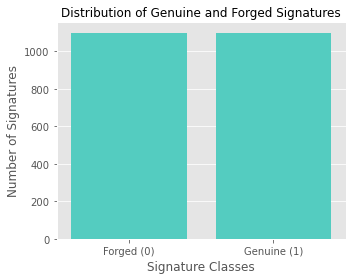

In [126]:
# input code to plot bar charts
y = []
unique_labels = unique(labels)
for x in unique_labels:
    y.append(np.count_nonzero(labels == x))

x_labels = []
for i in unique_labels:
    if i == 0:
        x_labels.append('Forged (0)')
    else:
        x_labels.append('Genuine (1)')

plt.rcParams["figure.figsize"] = (5, 4)
plt.title('Distribution of Genuine and Forged Signatures', fontsize=12)
sns.barplot(x=x_labels, y=y, color='turquoise')
plt.xlabel('Signature Classes', fontsize=12)
plt.ylabel('Number of Signatures', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

### Image Shape and Labels
Displays the label and shape of each sample image, which is (150, 150).

Text(2, 2, '0')

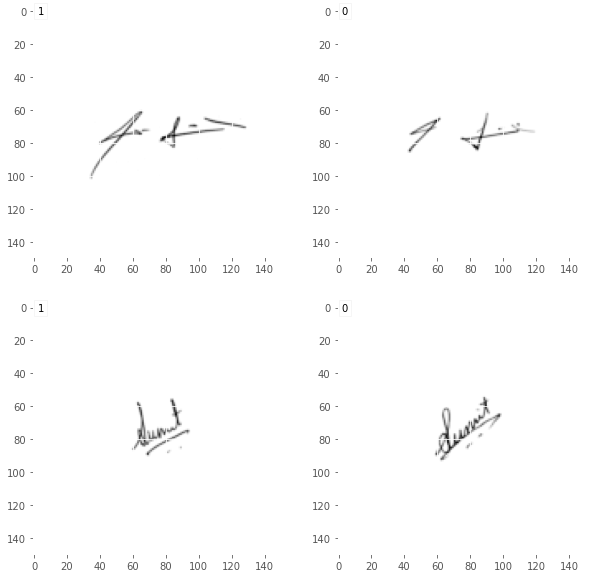

In [127]:
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
axarr[0, 0].imshow(features[1101]/255., cmap='gray')
axarr[0, 0].text(2, 2, labels[1101], bbox={'facecolor': 'white', 'pad': 3})
axarr[0, 1].imshow(features[0]/255., cmap='gray')
axarr[0, 1].text(2, 2, labels[0], bbox={'facecolor': 'white', 'pad': 3})
axarr[1, 0].imshow(features[1301]/255., cmap='gray')
axarr[1, 0].text(2, 2, labels[1301], bbox={'facecolor': 'white', 'pad': 3})
axarr[1, 1].imshow(features[201]/255., cmap='gray')
axarr[1, 1].text(2, 2, labels[201], bbox={'facecolor': 'white', 'pad': 3})

### Genuine and Forged Signatures of each Person
Function randomly selects a genuine signature of a person from train dataset and selects one genuine copy and one forged copy of signatures of the same person, and displays them accordingly.

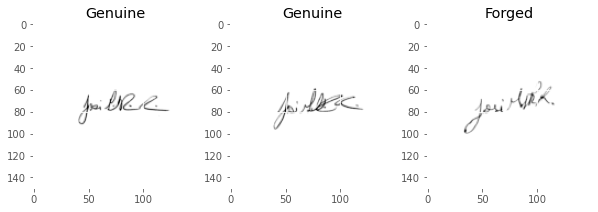

In [135]:
visualize_signatures()

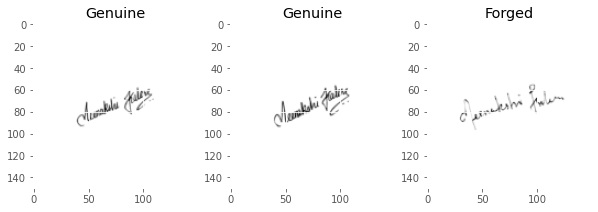

In [141]:
visualize_signatures()

[[Back to Table of Contents]](#Table-of-Contents)

## Models
Before we build our Signature Verification Model using deep learning deep learning, we will first look at Baseline model and how simple built-in functions in sklearn, MSE and SSIM can be used to detect differences in two images. However, these functions have their limitations.

Next, we will build models using Convolutional Neural Networks (CNN), Siamese Neural Networks, and briefly experiment with transfer learning using a pre-trained model such as InceptionV3.


### Baseline Model

Our problem statement is a binary classification problem, where label 1 represents a genuine signature and label 0 represents a forged signature. For a two outcome/binary model, it will be right more often than not by just going with the odds. Selecting the majority group (ZeroR classifier) is insightful as a baseline. In this case, we have a balanced classification problem, hence we will just use 0.50 as the baseline accuracy score.

### Similarity in Images using MSE and SSIM

Mean Squared Error (MSE) and Structural Similarity Index (SSIM) are used to compute similarities between two images. These functions can be found in the sklearn library.

MSE does not have a fixed bound, and a higher number means a higher dissimilarity, whereas SSIM has a fixed bound between -1 and 1, where 1 means a perfect match between two images.

We will look at the MSE and SSIM for two examples below:
1. Genuine-Forged pairs of images
    - <i>MSE Error: 42.80746666666667</i>
    - <i>SSIM: 0.9384314910047251</i>
2. Genuine-Genuine pairs of images
    - <i>MSE Error: 65.84168888888888</i>
    - <i>SSIM: 0.8892803875742811</i>

Even though these functions can help detect unskilled forgeries, in cases like the below skilled forgery for the genuine-forged pair of signatures, the MSE error is smaller than that of the genuine-genuine pair, when the opposite should be true. Similarly, the SSIM for the genuine-forged pair is higher than that of the genuine-genuine pairs (which will almost never be identical). 

Hence, we cannot use MSE and SSIM for verifying signatures.

#### Genuine-Forged Pairs

In [36]:
A = features_dict["forged_1_1.png"]  # forged
B = features_dict["genuine_1_1.png"]  # genuine

Signature: Forged


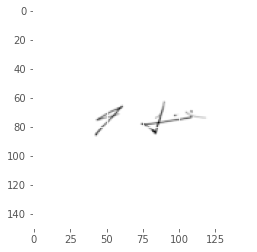

Signature: Genuine


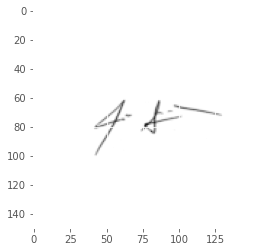

In [37]:
print("Signature: {}".format(convert_label_to_text(A[1])))
plt.imshow(A[0], cmap='gray')
plt.show()

print("Signature: {}".format(convert_label_to_text(B[1])))
plt.imshow(B[0], cmap='gray')
plt.show()

In [38]:
A_array = img_to_array(A[0])
B_array = img_to_array(B[0])
print('MSE Error: {}'.format(mse(A_array, B_array)))
print('SSIM: {}'.format(ssim(A_array.flatten(), B_array.flatten())))

MSE Error: 42.80746666666667
SSIM: 0.9384314910047251


#### Genuine-Genuine Pairs

In [39]:
C = features_dict['genuine_8_2.png']  # genuine
D = features_dict['genuine_8_3.png']  # genuine

Signature: Genuine


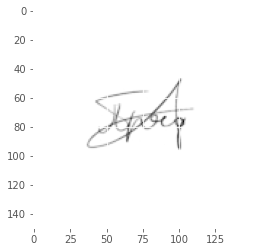

Signature: Genuine


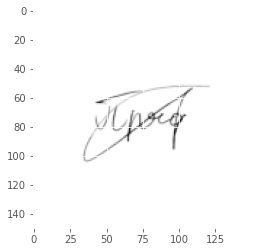

In [40]:
print('Signature: {}'.format(convert_label_to_text(C[0])))
plt.imshow(C[0], cmap='gray')
plt.show()

print('Signature: {}'.format(convert_label_to_text(D[0])))
plt.imshow(D[0], cmap='gray')
plt.show()

In [37]:
C_array = img_to_array(C[0])
D_array = img_to_array(D[0])
print('MSE Error: {}'.format(mse(C_array, D_array)))
print('SSIM: {}'.format(ssim(C_array.flatten(), D_array.flatten())))

MSE Error: 65.84168888888888
SSIM: 0.8892803875742811


[[Back to Table of Contents]](#Table-of-Contents)

### CNN Classifier
There are limitations of using CNN Classifier for this problem statement as we only have 20 genuine and 20 forged signatures for each of the 55 people. With this lack of data, the model is likely to overfit.

In [143]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(
    64, (3, 3), input_shape=(150, 150, 1), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(512, activation='relu'))
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam',
            loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [144]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 16)      

In [145]:
# normalize inputs
X_train /= 255.
X_val /= 255.
X_test /= 255.

In [146]:
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/cnn-model-{epoch:02d}.h5', verbose=1, save_weights_only=True)
]

In [147]:
cnn_history = cnn.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.6932 - acc: 0.5020
Epoch 1: saving model to ../weights\cnn-model-01.h5
39/39 [==============================] - 2s 33ms/step - loss: 0.6932 - acc: 0.5020 - val_loss: 0.6989 - val_acc: 0.4552
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5107
Epoch 2: saving model to ../weights\cnn-model-02.h5
39/39 [==============================] - 1s 29ms/step - loss: 0.6931 - acc: 0.5101 - val_loss: 0.6939 - val_acc: 0.4552
Epoch 3/50
37/39 [===========================>..] - ETA: 0s - loss: 0.6931 - acc: 0.5101
Epoch 3: saving model to ../weights\cnn-model-03.h5
39/39 [==============================] - 1s 29ms/step - loss: 0.6931 - acc: 0.5101 - val_loss: 0.6936 - val_acc: 0.4552
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 0.6931 - acc: 0.5101
Epoch 4: saving model to ../weights\cnn-model-04.h5
39/39 [==============================] - 1s 30ms/step - loss: 0.6931 - acc: 

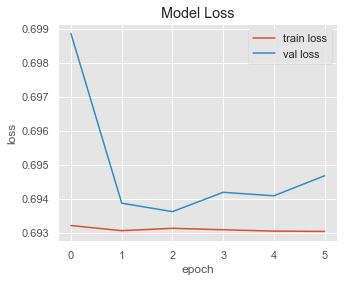

Train Loss:  0.6930504441261292
Validation Loss:  0.6946852803230286


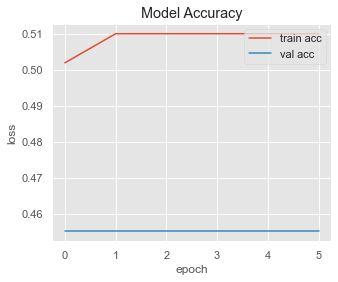

Train Accuracy:  0.5101050734519958
Validation Accuracy:  0.4552057981491089


In [148]:
plot_history(cnn_history)

In [ ]:
Despite using

In [152]:
preds = cnn.predict(X_test)
pred_labels = []

In [153]:
# threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)

In [154]:
print('Accuracy on test dataset: {}'.format(
    accuracy_score(y_test, pred_labels)))

Accuracy on test dataset: 0.5109090909090909


In [160]:
cnn = tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(
    64, (3, 3), input_shape=(150, 150, 1), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(2))
cnn.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(512, activation='relu'))
cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
cnn.compile(optimizer='RMSProp',
            loss=tf.keras.losses.binary_crossentropy, metrics=['acc'])

In [161]:
cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 17, 17, 16)      

In [162]:
callbacks = [
    EarlyStopping(patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/cnn-rms-model-{epoch:02d}.h5', verbose=1, save_weights_only=True)
]

In [163]:
cnn_history = cnn.fit(X_train, y_train, epochs=50,
                      validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.6975 - acc: 0.5085
Epoch 1: saving model to ../weights\cnn-rms-model-01.h5
39/39 [==============================] - 2s 39ms/step - loss: 0.6975 - acc: 0.5085 - val_loss: 0.6935 - val_acc: 0.4552
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.6933 - acc: 0.5101
Epoch 2: saving model to ../weights\cnn-rms-model-02.h5
39/39 [==============================] - 1s 35ms/step - loss: 0.6933 - acc: 0.5101 - val_loss: 0.6937 - val_acc: 0.4552
Epoch 3/50
37/39 [===========================>..] - ETA: 0s - loss: 0.6935 - acc: 0.4890
Epoch 3: saving model to ../weights\cnn-rms-model-03.h5
39/39 [==============================] - 1s 35ms/step - loss: 0.6934 - acc: 0.4907 - val_loss: 0.6939 - val_acc: 0.4552
Epoch 4/50
37/39 [===========================>..] - ETA: 0s - loss: 0.6932 - acc: 0.5068
Epoch 4: saving model to ../weights\cnn-rms-model-04.h5
39/39 [==============================] - 1s 32ms/step - loss

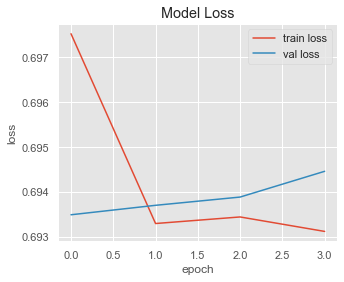

Train Loss:  0.6931211352348328
Validation Loss:  0.6944618225097656


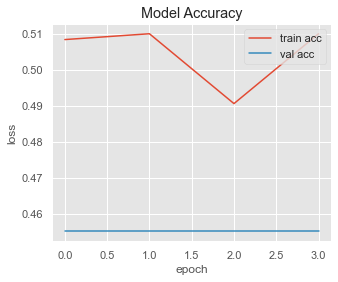

Train Accuracy:  0.5101050734519958
Validation Accuracy:  0.4552057981491089


In [164]:
plot_history(cnn_history)

Despite using ReduceLROnPlateau to reduce rate of learning and EarlyStopping to fine tune the model, the model's validation loss did not decrease.

[[Back to Table of Contents]](#Table-of-Contents)

### Siamese Neural Networks

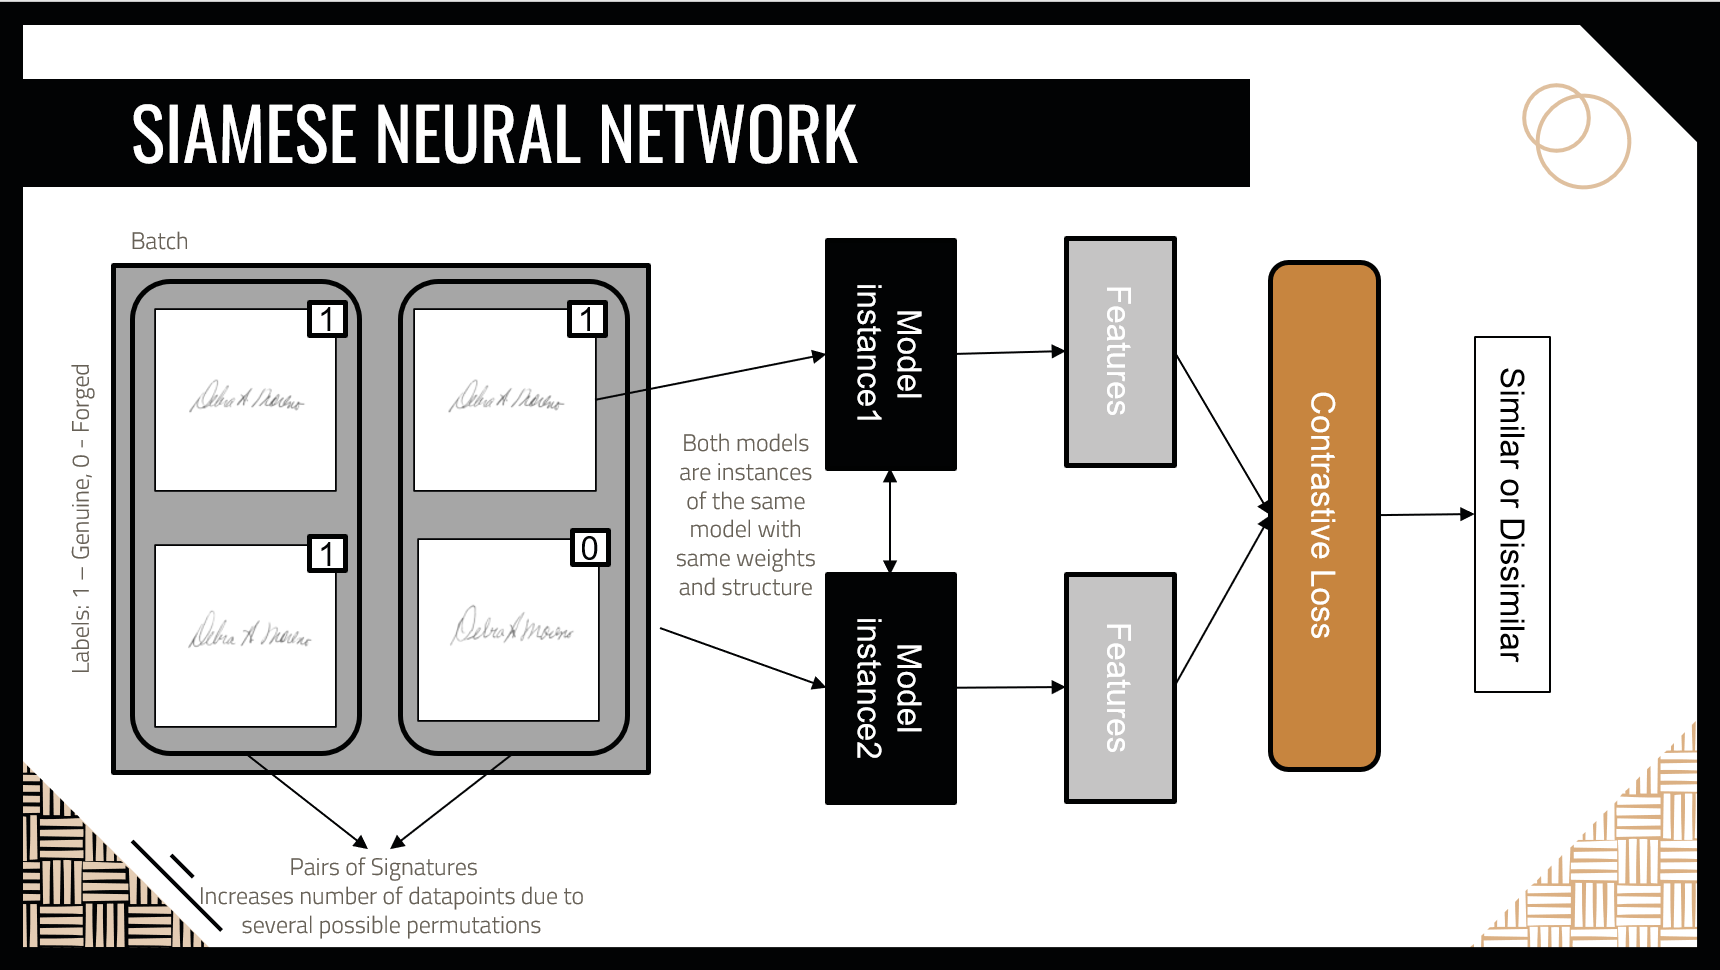

With the lack of training data, this means that the deep learning models such as the CNN Classifier Model we built earlier, will not be able to classify classes properly and will perform poorly. This is where Siamese Neural Networks come in. The siamese network is fed with pairs of images and their corresponding labels (similar or dissimilar). Because of this reason, more data can be generated for training the model as we can create many different pairs of permutated signatures. 

A Siamese network is a class of neural networks that contains one or more identical networks. In our use case, we will feed a pair of signatures (genuine-genuine or genuine-forged) and their corresponding labels (1 for genuine pairs, and 0 for genuine-forged pairs) to these networks. Each of these network will then compute the features of one input. And, then the similarity of features is computed using their difference. For same class input pairs, target output is 1 and for different classes input pairs, the output is 0.

Hence, to build the SNN model, we will need to create signature pairs and label them accordingly, and then feed these signature pairs to the SNN to train the model.

Fine-tuning was done through the use of different optimizers including Adam, Adagrad, RMSprop and SGD, EarlyStopping, adjusting batch size and learning rate.

In [45]:
# To ensure that all images will be the same size
img_h, img_w = 150, 150

In [46]:
input_shape = (img_h, img_w, 1)

In [47]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)(
    [processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [48]:
batch_size = 256
num_train_samples = 190*41 + 400*41
num_val_samples = num_test_samples = 190*7 + 400*7
num_train_samples, num_val_samples, num_test_samples

(24190, 4130, 4130)

#### RMSProp

<b>Accuracy: 72.2% (learning rate: 1e-4, batch_size = 32)</b>

In [85]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [86]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le4-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [87]:
results = model.fit(generate_batch(genuine_train, forged_train, 32),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
754/755 [============================>.] - ETA: 0s - loss: 0.5685 - acc: 0.4971
Epoch 1: saving model to ../weights\snn-rms-le4-32-model-01.h5
755/755 [==============================] - 30s 37ms/step - loss: 0.5683 - acc: 0.4971 - val_loss: 0.6087 - val_acc: 0.5073
Epoch 2/200
755/755 [==============================] - ETA: 0s - loss: 0.3191 - acc: 0.5027
Epoch 2: saving model to ../weights\snn-rms-le4-32-model-02.h5
755/755 [==============================] - 32s 42ms/step - loss: 0.3191 - acc: 0.5027 - val_loss: 0.5482 - val_acc: 0.5170
Epoch 3/200
755/755 [==============================] - ETA: 0s - loss: 0.2766 - acc: 0.5024
Epoch 3: saving model to ../weights\snn-rms-le4-32-model-03.h5
755/755 [==============================] - 32s 42ms/step - loss: 0.2766 - acc: 0.5024 - val_loss: 0.5247 - val_acc: 0.5119
Epoch 4/200
754/755 [============================>.] - ETA: 0s - loss: 0.2656 - acc: 0.5040
Epoch 4: saving model to ../weights\snn-rms-le4-32-model-04.h5
755/755 [==

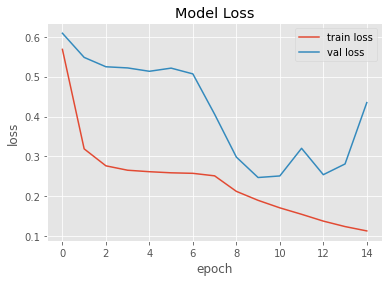

Train Loss:  0.11358853429555893
Validation Loss:  0.43493103981018066


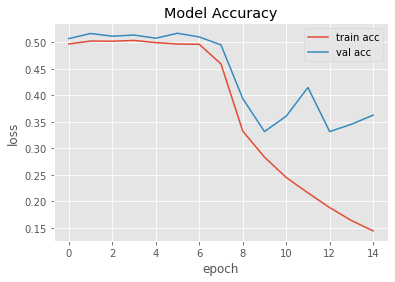

Train Accuracy:  0.1439155638217926
Validation Accuracy:  0.36264535784721375


In [88]:
plot_history(results)

In [50]:
acc, threshold = test_model('../weights/snn-rms-le4-32-model-08.h5')
acc, threshold

(0.7221505162944097, 0.1419522795919329)

<b> Accuracy: 69.15% (learning rate: 1e-4, batch_size = 64)</b>

In [39]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le4-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [41]:
results = model.fit(generate_batch(genuine_train, forged_train, 64),
                    steps_per_epoch=num_train_samples//64,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/200
376/377 [============================>.] - ETA: 0s - loss: 1.1964 - acc: 0.4998
Epoch 1: saving model to ../weights\snn-rms-le4-64-model-01.h5
377/377 [==============================] - 24s 52ms/step - loss: 1.1947 - acc: 0.4999 - val_loss: 0.8000 - val_acc: 0.5115
Epoch 2/200
377/377 [==============================] - ETA: 0s - loss: 0.4362 - acc: 0.4999
Epoch 2: saving model to ../weights\snn-rms-le4-64-model-02.h5
377/377 [==============================] - 19s 50ms/step - loss: 0.4362 - acc: 0.4999 - val_loss: 0.6259 - val_acc: 0.5159
Epoch 3/200
376/377 [============================>.] - ETA: 0s - loss: 0.3377 - acc: 0.4981
Epoch 3: saving model to ../weights\snn-rms-le4-64-model-03.h5
377/377 [==============================] - 19s 50ms/step - loss: 0.3377 - acc: 0.4981 - val_loss: 0.5635 - val_acc: 0.5085
Epoch 4/200
376/377 [============================>.] - ETA: 0s - loss: 0.3010 - acc: 0.5055
Epoch 4: saving model to ../weights\snn-rms-le4-64-model-04.h5
377/377 [==

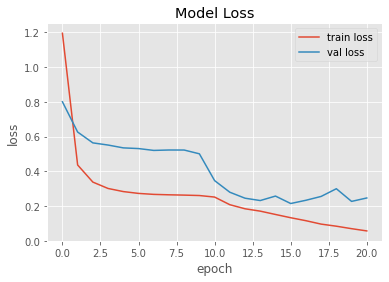

Train Loss:  0.0565560944378376
Validation Loss:  0.24623343348503113


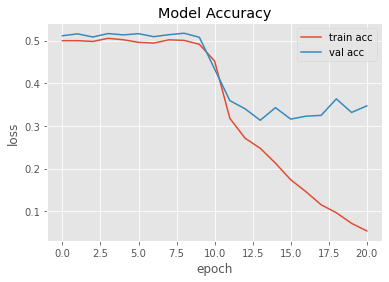

Train Accuracy:  0.053630635142326355
Validation Accuracy:  0.346923828125


In [42]:
plot_history(results)

In [51]:
acc, threshold = test_model('../weights\snn-rms-le4-64-model-11.h5')
acc, threshold

(0.6856942611653617, 0.29105256552342323)

<b>Accuracy: 72.1% (learning_rate=1e4, batch_size=256)<b>

In [39]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le4-256-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [41]:
results = model.fit(generate_batch(genuine_train, forged_train, 256),
                    steps_per_epoch=num_train_samples//256,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 256),
                    validation_steps=num_val_samples//256,
                    callbacks=callbacks)

Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 2.5495 - acc: 0.4955
Epoch 1: saving model to ../weights\snn-rms-le4-256-model-01.h5
94/94 [==============================] - 22s 185ms/step - loss: 2.5495 - acc: 0.4955 - val_loss: 1.2859 - val_acc: 0.5105
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 0.9652 - acc: 0.5024
Epoch 2: saving model to ../weights\snn-rms-le4-256-model-02.h5
94/94 [==============================] - 16s 170ms/step - loss: 0.9652 - acc: 0.5024 - val_loss: 1.0884 - val_acc: 0.5115
Epoch 3/200
94/94 [==============================] - ETA: 0s - loss: 0.7382 - acc: 0.4966
Epoch 3: saving model to ../weights\snn-rms-le4-256-model-03.h5
94/94 [==============================] - 16s 171ms/step - loss: 0.7382 - acc: 0.4966 - val_loss: 0.8910 - val_acc: 0.5127
Epoch 4/200
94/94 [==============================] - ETA: 0s - loss: 0.5745 - acc: 0.4955
Epoch 4: saving model to ../weights\snn-rms-le4-256-model-04.h5
94/94 [===========

94/94 [==============================] - 16s 173ms/step - loss: 0.1352 - acc: 0.1737 - val_loss: 0.2176 - val_acc: 0.3057
Epoch 31/200
94/94 [==============================] - ETA: 0s - loss: 0.1223 - acc: 0.1523
Epoch 31: saving model to ../weights\snn-rms-le4-256-model-31.h5
94/94 [==============================] - 16s 171ms/step - loss: 0.1223 - acc: 0.1523 - val_loss: 0.2097 - val_acc: 0.3088
Epoch 32/200
94/94 [==============================] - ETA: 0s - loss: 0.1041 - acc: 0.1224
Epoch 32: saving model to ../weights\snn-rms-le4-256-model-32.h5
94/94 [==============================] - 16s 172ms/step - loss: 0.1041 - acc: 0.1224 - val_loss: 0.2572 - val_acc: 0.3474
Epoch 33/200
94/94 [==============================] - ETA: 0s - loss: 0.0911 - acc: 0.1019
Epoch 33: saving model to ../weights\snn-rms-le4-256-model-33.h5
94/94 [==============================] - 16s 172ms/step - loss: 0.0911 - acc: 0.1019 - val_loss: 0.2433 - val_acc: 0.3088
Epoch 34/200
94/94 [========================

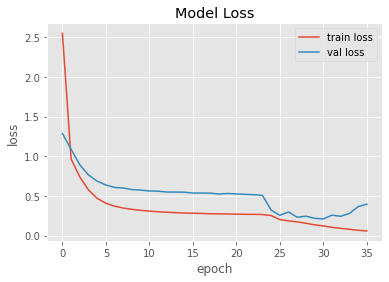

Train Loss:  0.05888799577951431
Validation Loss:  0.3967185616493225


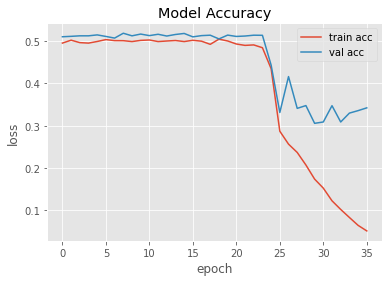

Train Accuracy:  0.05111369863152504
Validation Accuracy:  0.34228515625


In [42]:
plot_history(results)

In [58]:
acc, threshold = test_model('../weights\snn-rms-le4-256-model-25.h5')
acc, threshold

(0.7234961611727903, 0.2139726598188281)

<b>Accuracy: 69.9% (learning_rate=1e-5, batch_size=32)</b>

In [43]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-5, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [44]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le5-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [45]:
results = model.fit(generate_batch(genuine_train, forged_train, 32),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
755/755 [==============================] - ETA: 0s - loss: 0.2776 - acc: 0.4935
Epoch 1: saving model to ../weights\snn-rms-le5-32-model-01.h5
755/755 [==============================] - 28s 34ms/step - loss: 0.2776 - acc: 0.4935 - val_loss: 0.5333 - val_acc: 0.5145
Epoch 2/200
755/755 [==============================] - ETA: 0s - loss: 0.2764 - acc: 0.4923
Epoch 2: saving model to ../weights\snn-rms-le5-32-model-02.h5
755/755 [==============================] - 26s 34ms/step - loss: 0.2764 - acc: 0.4923 - val_loss: 0.5258 - val_acc: 0.5138
Epoch 3/200
754/755 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.4704
Epoch 3: saving model to ../weights\snn-rms-le5-32-model-03.h5
755/755 [==============================] - 26s 34ms/step - loss: 0.2727 - acc: 0.4704 - val_loss: 0.4928 - val_acc: 0.5131
Epoch 4/200
754/755 [============================>.] - ETA: 0s - loss: 0.2091 - acc: 0.2891
Epoch 4: saving model to ../weights\snn-rms-le5-32-model-04.h5
755/755 [==

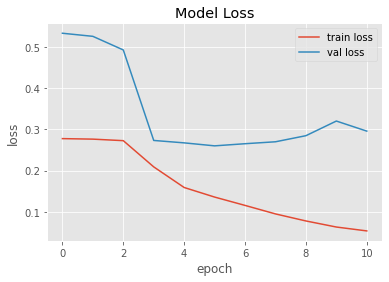

Train Loss:  0.05363461375236511
Validation Loss:  0.29582035541534424


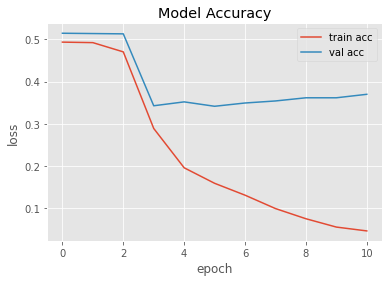

Train Accuracy:  0.046357616782188416
Validation Accuracy:  0.3699128031730652


In [46]:
plot_history(results)

In [59]:
acc, threshold = test_model('../weights\snn-rms-le5-32-model-03.h5')
acc, threshold

(0.6920656460152741, 0.035612780805677174)

<b>Accuracy: 68.2% (learning_rate=1e-5, batch_size=64</b>

In [39]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-5, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [43]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le5-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [44]:
results = model.fit(generate_batch(genuine_train, forged_train, 64),
                    steps_per_epoch=num_train_samples//64,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/200
376/377 [============================>.] - ETA: 0s - loss: 0.2831 - acc: 0.4911
Epoch 1: saving model to ../weights\snn-rms-le5-64-model-01.h5
377/377 [==============================] - 19s 50ms/step - loss: 0.2831 - acc: 0.4912 - val_loss: 0.5438 - val_acc: 0.5144
Epoch 2/200
377/377 [==============================] - ETA: 0s - loss: 0.2835 - acc: 0.5052
Epoch 2: saving model to ../weights\snn-rms-le5-64-model-02.h5
377/377 [==============================] - 19s 50ms/step - loss: 0.2835 - acc: 0.5052 - val_loss: 0.5383 - val_acc: 0.5100
Epoch 3/200
376/377 [============================>.] - ETA: 0s - loss: 0.2818 - acc: 0.4953
Epoch 3: saving model to ../weights\snn-rms-le5-64-model-03.h5
377/377 [==============================] - 19s 50ms/step - loss: 0.2818 - acc: 0.4956 - val_loss: 0.5396 - val_acc: 0.5120
Epoch 4/200
376/377 [============================>.] - ETA: 0s - loss: 0.2816 - acc: 0.4990
Epoch 4: saving model to ../weights\snn-rms-le5-64-model-04.h5
377/377 [==

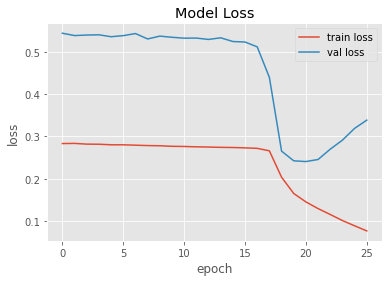

Train Loss:  0.07667550444602966
Validation Loss:  0.33846068382263184


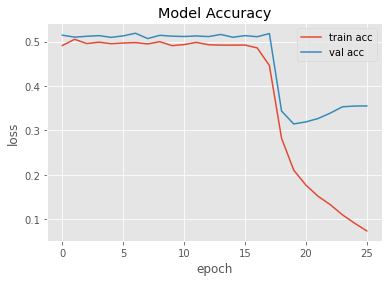

Train Accuracy:  0.07402188330888748
Validation Accuracy:  0.355224609375


In [45]:
plot_history(results)

In [60]:
acc, threshold = test_model('../weights\snn-rms-le5-64-model-18.h5')
acc, threshold

(0.674306537011282, 0.0898449243232608)

<b>Accuracy 70.7% (learning_rate=1e-5, batch_size=256)<b>

In [36]:
# compile model using  RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-5, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [37]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-rms-le5-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [38]:
results = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//batch_size,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, batch_size),
                    validation_steps=num_val_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 9.9733 - acc: 0.4859 
Epoch 1: saving model to ../weights\snn-rms-le5-model-01.h5
120/120 [==============================] - 21s 138ms/step - loss: 9.9733 - acc: 0.4859 - val_loss: 1.3219 - val_acc: 0.5130
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 1.0712 - acc: 0.4929
Epoch 2: saving model to ../weights\snn-rms-le5-model-02.h5
120/120 [==============================] - 16s 131ms/step - loss: 1.0712 - acc: 0.4929 - val_loss: 1.3057 - val_acc: 0.5157
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 1.0334 - acc: 0.4922
Epoch 3: saving model to ../weights\snn-rms-le5-model-03.h5
120/120 [==============================] - 16s 130ms/step - loss: 1.0334 - acc: 0.4922 - val_loss: 1.2679 - val_acc: 0.5110
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 1.0001 - acc: 0.4983
Epoch 4: saving model to ../weights\snn-rms-le5-model-04.h5
120/120 [==========

120/120 [==============================] - 16s 133ms/step - loss: 0.4463 - acc: 0.4958 - val_loss: 0.7013 - val_acc: 0.5167
Epoch 31/100
120/120 [==============================] - ETA: 0s - loss: 0.4389 - acc: 0.4998
Epoch 31: saving model to ../weights\snn-rms-le5-model-31.h5
120/120 [==============================] - 16s 134ms/step - loss: 0.4389 - acc: 0.4998 - val_loss: 0.6901 - val_acc: 0.5130
Epoch 32/100
120/120 [==============================] - ETA: 0s - loss: 0.4313 - acc: 0.4965
Epoch 32: saving model to ../weights\snn-rms-le5-model-32.h5
120/120 [==============================] - 16s 133ms/step - loss: 0.4313 - acc: 0.4965 - val_loss: 0.6795 - val_acc: 0.5085
Epoch 33/100
120/120 [==============================] - ETA: 0s - loss: 0.4240 - acc: 0.4966
Epoch 33: saving model to ../weights\snn-rms-le5-model-33.h5
120/120 [==============================] - 16s 134ms/step - loss: 0.4240 - acc: 0.4966 - val_loss: 0.6800 - val_acc: 0.5157
Epoch 34/100
120/120 [====================

120/120 [==============================] - ETA: 0s - loss: 0.3359 - acc: 0.4913
Epoch 60: saving model to ../weights\snn-rms-le5-model-60.h5
120/120 [==============================] - 16s 133ms/step - loss: 0.3359 - acc: 0.4913 - val_loss: 0.5888 - val_acc: 0.5100
Epoch 61/100
120/120 [==============================] - ETA: 0s - loss: 0.3344 - acc: 0.4980
Epoch 61: saving model to ../weights\snn-rms-le5-model-61.h5
120/120 [==============================] - 16s 133ms/step - loss: 0.3344 - acc: 0.4980 - val_loss: 0.5922 - val_acc: 0.5150
Epoch 62/100
120/120 [==============================] - ETA: 0s - loss: 0.3327 - acc: 0.4975
Epoch 62: saving model to ../weights\snn-rms-le5-model-62.h5
120/120 [==============================] - 16s 133ms/step - loss: 0.3327 - acc: 0.4975 - val_loss: 0.5845 - val_acc: 0.5088
Epoch 63/100
120/120 [==============================] - ETA: 0s - loss: 0.3305 - acc: 0.4905
Epoch 63: saving model to ../weights\snn-rms-le5-model-63.h5
120/120 [================

120/120 [==============================] - 17s 139ms/step - loss: 0.1841 - acc: 0.1898 - val_loss: 0.2835 - val_acc: 0.3397
Epoch 90/100
120/120 [==============================] - ETA: 0s - loss: 0.1725 - acc: 0.1712
Epoch 90: saving model to ../weights\snn-rms-le5-model-90.h5
120/120 [==============================] - 17s 138ms/step - loss: 0.1725 - acc: 0.1712 - val_loss: 0.2870 - val_acc: 0.3500
Epoch 91/100
120/120 [==============================] - ETA: 0s - loss: 0.1653 - acc: 0.1650
Epoch 91: saving model to ../weights\snn-rms-le5-model-91.h5
120/120 [==============================] - 17s 138ms/step - loss: 0.1653 - acc: 0.1650 - val_loss: 0.2698 - val_acc: 0.3327
Epoch 92/100
120/120 [==============================] - ETA: 0s - loss: 0.1538 - acc: 0.1504
Epoch 92: saving model to ../weights\snn-rms-le5-model-92.h5
120/120 [==============================] - 17s 138ms/step - loss: 0.1538 - acc: 0.1504 - val_loss: 0.2716 - val_acc: 0.3430
Epoch 93/100
120/120 [====================

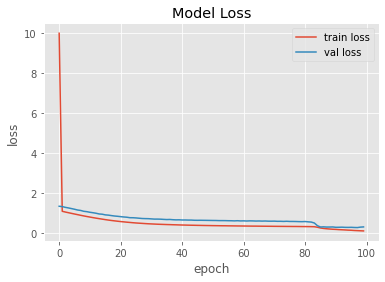

Train Loss:  0.08912274241447449
Validation Loss:  0.2890637218952179


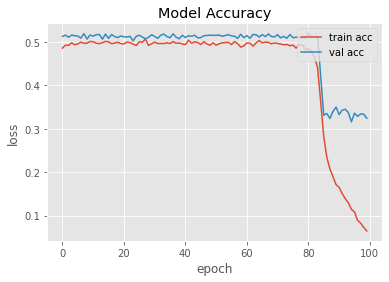

Train Accuracy:  0.06449999660253525
Validation Accuracy:  0.3242500126361847


In [39]:
plot_history(results)

In [61]:
acc, threshold = test_model('../weights\snn-rms-le5-model-82.h5')
acc, threshold

(0.7170259891012917, 0.01377738568931818)

[[Back to Table of Contents]](#Table-of-Contents)

#### Adagrad

<b>Accuracy: 50% (learning_rate=1e-4, batch_size=32)</b>

In [44]:
# compile model using Adagrad Optimizer and Contrastive loss function defined above
adagrad = Adagrad(learning_rate=1e-4)
model.compile(loss=contrastive_loss, optimizer=adagrad, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [45]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adagrad-1e4-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [46]:
results = model.fit(generate_batch(genuine_train, forged_train, 32),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
755/755 [==============================] - ETA: 0s - loss: 1.0748 - acc: 0.5049
Epoch 1: saving model to ../weights\snn-adagrad-1e4-32-model-01.h5
755/755 [==============================] - 24s 30ms/step - loss: 1.0748 - acc: 0.5049 - val_loss: 1.3236 - val_acc: 0.5070
Epoch 2/200
753/755 [============================>.] - ETA: 0s - loss: 1.0728 - acc: 0.4935
Epoch 2: saving model to ../weights\snn-adagrad-1e4-32-model-02.h5
755/755 [==============================] - 22s 29ms/step - loss: 1.0728 - acc: 0.4935 - val_loss: 1.3344 - val_acc: 0.5199
Epoch 3/200
755/755 [==============================] - ETA: 0s - loss: 1.0727 - acc: 0.4983
Epoch 3: saving model to ../weights\snn-adagrad-1e4-32-model-03.h5
755/755 [==============================] - 22s 30ms/step - loss: 1.0727 - acc: 0.4983 - val_loss: 1.3227 - val_acc: 0.5082
Epoch 4/200
755/755 [==============================] - ETA: 0s - loss: 1.0729 - acc: 0.5012
Epoch 4: saving model to ../weights\snn-adagrad-1e4-32-model-0

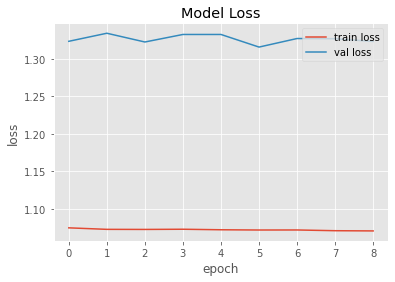

Train Loss:  1.070693850517273
Validation Loss:  1.3234089612960815


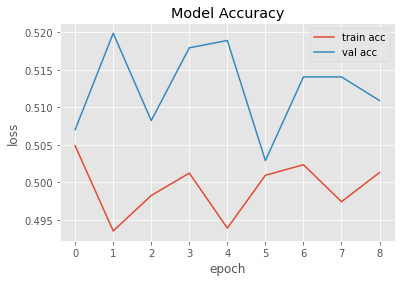

Train Accuracy:  0.501324474811554
Validation Accuracy:  0.510901153087616


In [47]:
plot_history(results)

In [62]:
acc, threshold = test_model('../weights\snn-adagrad-1e4-32-model-05.h5')
acc, threshold

(0.5, 0.01085893168579787)

<b>Accuracy: 50% (learning_rate=1e4, batch_size=256)

In [50]:
# compile model using Adagrad Optimizer and Contrastive loss function defined above
adagrad = Adagrad(learning_rate=1e-4)
model.compile(loss=contrastive_loss, optimizer=adagrad, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [51]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adagrad-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [52]:
results = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//batch_size,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, batch_size),
                    validation_steps=num_val_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.0756 - acc: 0.5002
Epoch 1: saving model to ../weights\snn-adagrad-model-01.h5
120/120 [==============================] - 17s 136ms/step - loss: 1.0756 - acc: 0.5002 - val_loss: 1.3334 - val_acc: 0.5138
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 1.0757 - acc: 0.4939
Epoch 2: saving model to ../weights\snn-adagrad-model-02.h5
120/120 [==============================] - 17s 139ms/step - loss: 1.0757 - acc: 0.4939 - val_loss: 1.3314 - val_acc: 0.5117
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 1.0758 - acc: 0.4963
Epoch 3: saving model to ../weights\snn-adagrad-model-03.h5
120/120 [==============================] - 17s 139ms/step - loss: 1.0758 - acc: 0.4963 - val_loss: 1.3309 - val_acc: 0.5117
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 1.0755 - acc: 0.4985
Epoch 4: saving model to ../weights\snn-adagrad-model-04.h5
120/120 [===========

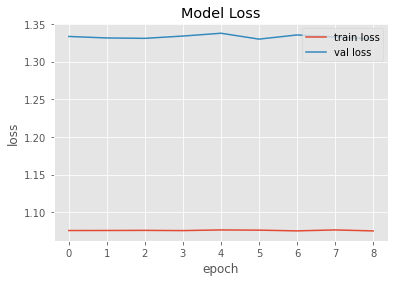

Train Loss:  1.0750980377197266
Validation Loss:  1.3300987482070923


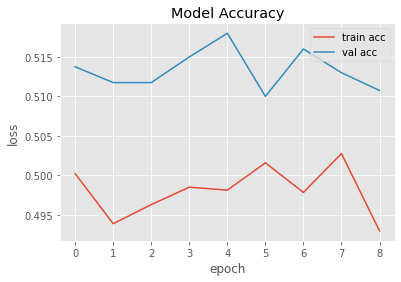

Train Accuracy:  0.49295833706855774
Validation Accuracy:  0.5107499957084656


In [53]:
plot_history(results)

In [63]:
acc, threshold = test_model('../weights\snn-adagrad-model-05.h5')
acc, threshold

(0.5002486325211337, 0.00011726211232598871)

<b>(learning_rate=1e-5, batch_size=64)

In [49]:
# compile model using Adagrad Optimizer and Contrastive loss function defined above
adagrad = Adagrad(learning_rate=1e-5)
model.compile(loss=contrastive_loss, optimizer=adagrad, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [50]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adagrad-1e5-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [51]:
results = model.fit(generate_batch(genuine_train, forged_train, 64),
                    steps_per_epoch=num_train_samples//64,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/200
377/377 [==============================] - ETA: 0s - loss: 1.0718 - acc: 0.4986
Epoch 1: saving model to ../weights\snn-adagrad-1e5-64-model-01.h5
377/377 [==============================] - 19s 48ms/step - loss: 1.0718 - acc: 0.4986 - val_loss: 1.3271 - val_acc: 0.5134
Epoch 2/200
377/377 [==============================] - ETA: 0s - loss: 1.0720 - acc: 0.5005
Epoch 2: saving model to ../weights\snn-adagrad-1e5-64-model-02.h5
377/377 [==============================] - 18s 47ms/step - loss: 1.0720 - acc: 0.5005 - val_loss: 1.3316 - val_acc: 0.5181
Epoch 3/200
377/377 [==============================] - ETA: 0s - loss: 1.0717 - acc: 0.4979
Epoch 3: saving model to ../weights\snn-adagrad-1e5-64-model-03.h5
377/377 [==============================] - 18s 48ms/step - loss: 1.0717 - acc: 0.4979 - val_loss: 1.3233 - val_acc: 0.5095
Epoch 4/200
376/377 [============================>.] - ETA: 0s - loss: 1.0720 - acc: 0.5020
Epoch 4: saving model to ../weights\snn-adagrad-1e5-64-model-0

[[Back to Table of Contents]](#Table-of-Contents)

#### Adam

<b>Accuracy: 65.6% (learning_rate:1e-4, batch_size=32)</b>

In [40]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [41]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e4-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [42]:
results = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
755/755 [==============================] - ETA: 0s - loss: 1.2800 - acc: 0.4998
Epoch 1: saving model to ../weights\snn-adam-1e4-32-model-01.h5
755/755 [==============================] - 116s 147ms/step - loss: 1.2800 - acc: 0.4998 - val_loss: 1.2251 - val_acc: 0.5087
Epoch 2/200
755/755 [==============================] - ETA: 0s - loss: 0.9216 - acc: 0.4971
Epoch 2: saving model to ../weights\snn-adam-1e4-32-model-02.h5
755/755 [==============================] - 112s 149ms/step - loss: 0.9216 - acc: 0.4971 - val_loss: 1.1297 - val_acc: 0.5167
Epoch 3/200
755/755 [==============================] - ETA: 0s - loss: 0.8210 - acc: 0.4982
Epoch 3: saving model to ../weights\snn-adam-1e4-32-model-03.h5
755/755 [==============================] - 111s 147ms/step - loss: 0.8210 - acc: 0.4982 - val_loss: 1.0299 - val_acc: 0.5131
Epoch 4/200
755/755 [==============================] - ETA: 0s - loss: 0.7281 - acc: 0.4993
Epoch 4: saving model to ../weights\snn-adam-1e4-32-model-04.h5
7

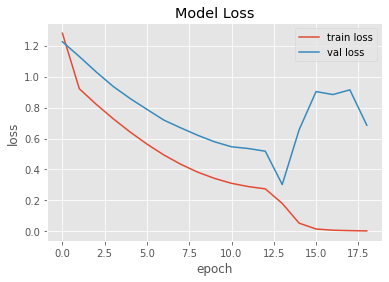

Train Loss:  0.0032795954030007124
Validation Loss:  0.686137855052948


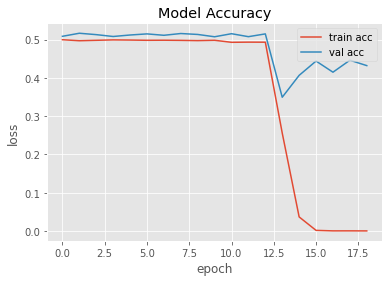

Train Accuracy:  0.0003466473426669836
Validation Accuracy:  0.4321705400943756


In [44]:
plot_history(results)

In [64]:
acc, threshold = test_model('../weights\snn-adam-1e4-32-model-13.h5')
acc, threshold

(0.663508589594095, 0.011151918550021947)

<b>Accuracy: 60.1% (learning_rate:1e-4, batch_size=64)</b>

In [39]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e4-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [41]:
results = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//64,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/200
377/377 [==============================] - ETA: 0s - loss: 1.4812 - acc: 0.5001
Epoch 1: saving model to ../weights\snn-adam-1e4-64-model-01.h5
377/377 [==============================] - 61s 150ms/step - loss: 1.4812 - acc: 0.5001 - val_loss: 1.2820 - val_acc: 0.5122
Epoch 2/200
377/377 [==============================] - ETA: 0s - loss: 1.0017 - acc: 0.4972
Epoch 2: saving model to ../weights\snn-adam-1e4-64-model-02.h5
377/377 [==============================] - 57s 150ms/step - loss: 1.0017 - acc: 0.4972 - val_loss: 1.2288 - val_acc: 0.5122
Epoch 3/200
377/377 [==============================] - ETA: 0s - loss: 0.9471 - acc: 0.5018
Epoch 3: saving model to ../weights\snn-adam-1e4-64-model-03.h5
377/377 [==============================] - 57s 151ms/step - loss: 0.9471 - acc: 0.5018 - val_loss: 1.1795 - val_acc: 0.5173
Epoch 4/200
377/377 [==============================] - ETA: 0s - loss: 0.8934 - acc: 0.4998
Epoch 4: saving model to ../weights\snn-adam-1e4-64-model-04.h5
377/

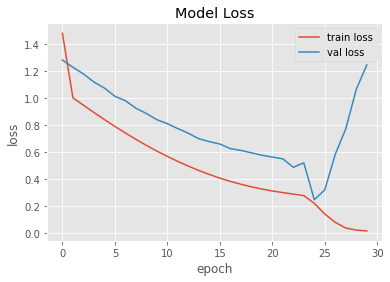

Train Loss:  0.014013226144015789
Validation Loss:  1.2457997798919678


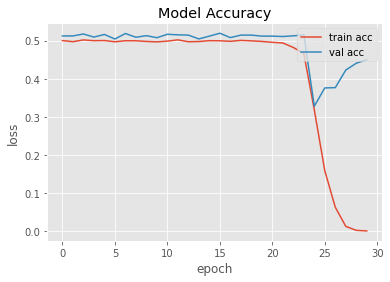

Train Accuracy:  0.0011915616923943162
Validation Accuracy:  0.4501953125


In [42]:
plot_history(results)

In [70]:
acc, threshold = test_model('../weights\snn-adam-1e4-64-model-24.h5')
acc, threshold

(0.5959101387895479, 0.010979602569714189)

<b>Accuracy: 64.8% (learning_rate=1e-4, batch_size=256)</b>

In [61]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-4)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [71]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e4-256-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [63]:
results = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//batch_size,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, batch_size),
                    validation_steps=num_val_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 0.2673 - acc: 0.4946
Epoch 1: saving model to ../weights\snn-adam-1e4-256-model-01.h5
94/94 [==============================] - 18s 181ms/step - loss: 0.2673 - acc: 0.4946 - val_loss: 0.5234 - val_acc: 0.5166
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 0.2657 - acc: 0.4912
Epoch 2: saving model to ../weights\snn-adam-1e4-256-model-02.h5
94/94 [==============================] - 17s 181ms/step - loss: 0.2657 - acc: 0.4912 - val_loss: 0.5160 - val_acc: 0.5103
Epoch 3/200
94/94 [==============================] - ETA: 0s - loss: 0.2639 - acc: 0.4874
Epoch 3: saving model to ../weights\snn-adam-1e4-256-model-03.h5
94/94 [==============================] - 17s 180ms/step - loss: 0.2639 - acc: 0.4874 - val_loss: 0.5189 - val_acc: 0.5151
Epoch 4/200
94/94 [==============================] - ETA: 0s - loss: 0.2635 - acc: 0.4880
Epoch 4: saving model to ../weights\snn-adam-1e4-256-model-04.h5
94/94 [=======

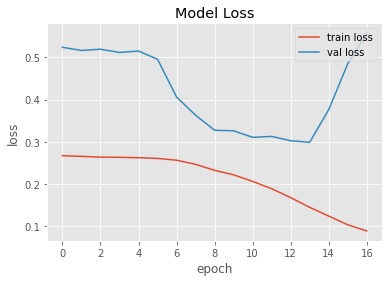

Train Loss:  0.08948016911745071
Validation Loss:  0.5566128492355347


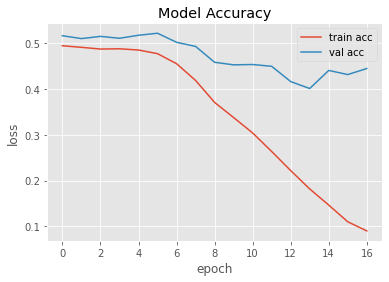

Train Accuracy:  0.08980219066143036
Validation Accuracy:  0.44482421875


In [67]:
plot_history(results)

In [72]:
acc, threshold = test_model('../weights\snn-adam-1e4-256-model-08.h5')
acc, threshold

(0.6539975817746919, 0.217573310751468)

<b>Accuracy: 65.9% (learning_rate=1e-5, batch_size=32)</b>


In [120]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-5)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          4888208     ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [121]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [122]:
results = model.fit(generate_batch(genuine_train, forged_train, 32),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
755/755 [==============================] - ETA: 0s - loss: 0.2579 - acc: 0.4827
Epoch 1: saving model to ../weights\snn-adam-32-model-01.h5
755/755 [==============================] - 25s 31ms/step - loss: 0.2579 - acc: 0.4827 - val_loss: 0.4854 - val_acc: 0.5102
Epoch 2/200
754/755 [============================>.] - ETA: 0s - loss: 0.2563 - acc: 0.4754
Epoch 2: saving model to ../weights\snn-adam-32-model-02.h5
755/755 [==============================] - 24s 31ms/step - loss: 0.2563 - acc: 0.4754 - val_loss: 0.4686 - val_acc: 0.5167
Epoch 3/200
754/755 [============================>.] - ETA: 0s - loss: 0.2411 - acc: 0.4082
Epoch 3: saving model to ../weights\snn-adam-32-model-03.h5
755/755 [==============================] - 23s 31ms/step - loss: 0.2411 - acc: 0.4082 - val_loss: 0.3370 - val_acc: 0.4554
Epoch 4/200
754/755 [============================>.] - ETA: 0s - loss: 0.2280 - acc: 0.3709
Epoch 4: saving model to ../weights\snn-adam-32-model-04.h5
755/755 [==============

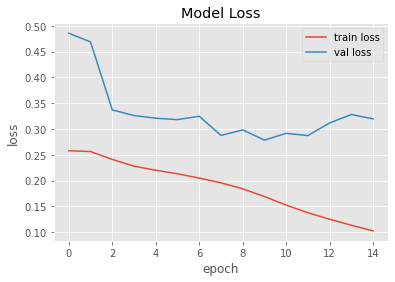

Train Loss:  0.10254640132188797
Validation Loss:  0.31952133774757385


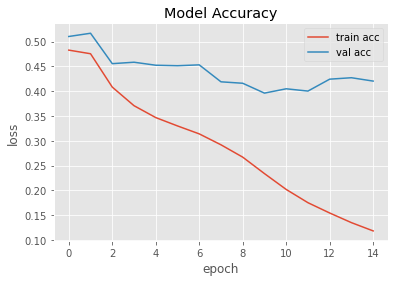

Train Accuracy:  0.1184188723564148
Validation Accuracy:  0.4203003942966461


In [123]:
plot_history(results)

In [73]:
acc, threshold = test_model('../weights\snn-adam-32-model-07.h5')
acc, threshold

(0.6622003284072249, 0.3585818711668254)

<b>Accuracy: 70.4% (learning_rate=1e-5, batch_size=64)</b>

In [55]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-5)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [56]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e5-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [57]:
results = model.fit(generate_batch(genuine_train, forged_train, 64),
                    steps_per_epoch=num_train_samples//64,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/200
376/377 [============================>.] - ETA: 0s - loss: 1.0185 - acc: 0.5011
Epoch 1: saving model to ../weights\snn-adam-1e5-64-model-01.h5
377/377 [==============================] - 20s 49ms/step - loss: 1.0184 - acc: 0.5007 - val_loss: 1.2378 - val_acc: 0.5129
Epoch 2/200
377/377 [==============================] - ETA: 0s - loss: 0.9529 - acc: 0.4955
Epoch 2: saving model to ../weights\snn-adam-1e5-64-model-02.h5
377/377 [==============================] - 18s 48ms/step - loss: 0.9529 - acc: 0.4955 - val_loss: 1.1766 - val_acc: 0.5117
Epoch 3/200
377/377 [==============================] - ETA: 0s - loss: 0.8960 - acc: 0.5007
Epoch 3: saving model to ../weights\snn-adam-1e5-64-model-03.h5
377/377 [==============================] - 18s 48ms/step - loss: 0.8960 - acc: 0.5007 - val_loss: 1.1266 - val_acc: 0.5159
Epoch 4/200
376/377 [============================>.] - ETA: 0s - loss: 0.8457 - acc: 0.5037
Epoch 4: saving model to ../weights\snn-adam-1e5-64-model-04.h5
377/377

376/377 [============================>.] - ETA: 0s - loss: 0.3138 - acc: 0.5020
Epoch 59: saving model to ../weights\snn-adam-1e5-64-model-59.h5
377/377 [==============================] - 18s 48ms/step - loss: 0.3138 - acc: 0.5020 - val_loss: 0.5696 - val_acc: 0.5110
Epoch 60/200
377/377 [==============================] - ETA: 0s - loss: 0.3118 - acc: 0.4987
Epoch 60: saving model to ../weights\snn-adam-1e5-64-model-60.h5
377/377 [==============================] - 18s 48ms/step - loss: 0.3118 - acc: 0.4987 - val_loss: 0.5719 - val_acc: 0.5149
Epoch 61/200
377/377 [==============================] - ETA: 0s - loss: 0.3103 - acc: 0.4920
Epoch 61: saving model to ../weights\snn-adam-1e5-64-model-61.h5
377/377 [==============================] - 18s 48ms/step - loss: 0.3103 - acc: 0.4920 - val_loss: 0.5641 - val_acc: 0.5083
Epoch 62/200
377/377 [==============================] - ETA: 0s - loss: 0.3090 - acc: 0.4936
Epoch 62: saving model to ../weights\snn-adam-1e5-64-model-62.h5
377/377 [===

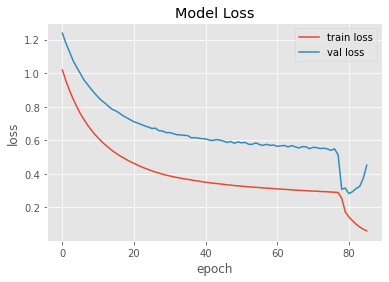

Train Loss:  0.059910453855991364
Validation Loss:  0.4518373906612396


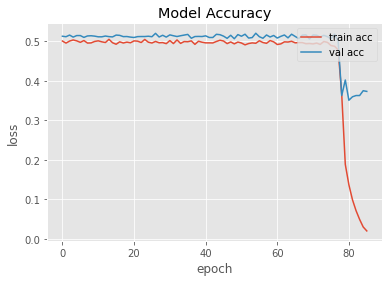

Train Accuracy:  0.020059682428836823
Validation Accuracy:  0.373291015625


In [62]:
plot_history(results)

In [74]:
acc, threshold = test_model('../weights\snn-adam-1e5-64-model-79.h5')
acc, threshold

(0.7032164205808681, 0.30279821619391445)

In [65]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-5)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

<b>Accuracy: 71.4% (learning_rate=1e5, batch_size=256) </b>

In [66]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e5-256-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [67]:
results = model.fit(generate_batch(genuine_train, forged_train, 256),
                    steps_per_epoch=num_train_samples//256,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 256),
                    validation_steps=num_val_samples//256,
                    callbacks=callbacks)

Epoch 1/200
94/94 [==============================] - ETA: 0s - loss: 0.1793 - acc: 0.1993
Epoch 1: saving model to ../weights\snn-adam-1e5-256-model-01.h5
94/94 [==============================] - 18s 185ms/step - loss: 0.1793 - acc: 0.1993 - val_loss: 0.3002 - val_acc: 0.3623
Epoch 2/200
94/94 [==============================] - ETA: 0s - loss: 0.1657 - acc: 0.1793
Epoch 2: saving model to ../weights\snn-adam-1e5-256-model-02.h5
94/94 [==============================] - 17s 181ms/step - loss: 0.1657 - acc: 0.1793 - val_loss: 0.2895 - val_acc: 0.3584
Epoch 3/200
94/94 [==============================] - ETA: 0s - loss: 0.1535 - acc: 0.1589
Epoch 3: saving model to ../weights\snn-adam-1e5-256-model-03.h5
94/94 [==============================] - 17s 181ms/step - loss: 0.1535 - acc: 0.1589 - val_loss: 0.2781 - val_acc: 0.3413
Epoch 4/200
94/94 [==============================] - ETA: 0s - loss: 0.1423 - acc: 0.1400
Epoch 4: saving model to ../weights\snn-adam-1e5-256-model-04.h5
94/94 [=======

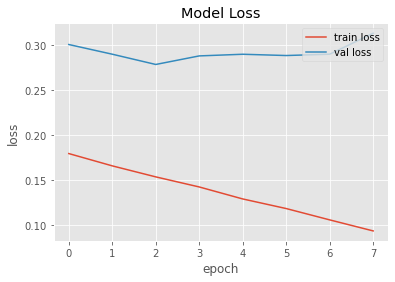

Train Loss:  0.09355690330266953
Validation Loss:  0.3127361238002777


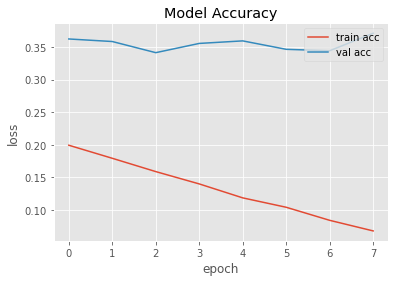

Train Accuracy:  0.06786070764064789
Validation Accuracy:  0.37109375


In [68]:
plot_history(results)

In [75]:
acc, threshold = test_model('../weights\snn-adam-1e5-256-model-02.h5')
acc, threshold

(0.7071407514228364, 0.31038893498480324)

<b>Accuracy: 50% (learning_rate=1e-6, batch_size=32)</b>

In [46]:
# compile model using adam Optimizer and Contrastive loss function defined above
adam = Adam(learning_rate=1e-6)
model.compile(optimizer=adam, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [47]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-adam-1e6-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [48]:
history = model.fit(generate_batch(genuine_train, forged_train, 32),
                    steps_per_epoch=num_train_samples//32,
                    epochs=200,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/200
755/755 [==============================] - ETA: 0s - loss: 1.2104 - acc: 0.4890
Epoch 1: saving model to ../weights\snn-adam-1e6-32-model-01.h5
755/755 [==============================] - 24s 30ms/step - loss: 1.2104 - acc: 0.4890 - val_loss: 1.3219 - val_acc: 0.5145
Epoch 2/200
754/755 [============================>.] - ETA: 0s - loss: 1.0726 - acc: 0.4925
Epoch 2: saving model to ../weights\snn-adam-1e6-32-model-02.h5
755/755 [==============================] - 22s 30ms/step - loss: 1.0726 - acc: 0.4926 - val_loss: 1.3142 - val_acc: 0.5109
Epoch 3/200
755/755 [==============================] - ETA: 0s - loss: 1.0592 - acc: 0.4973
Epoch 3: saving model to ../weights\snn-adam-1e6-32-model-03.h5
755/755 [==============================] - 22s 30ms/step - loss: 1.0592 - acc: 0.4973 - val_loss: 1.3078 - val_acc: 0.5133
Epoch 4/200
754/755 [============================>.] - ETA: 0s - loss: 1.0497 - acc: 0.4971
Epoch 4: saving model to ../weights\snn-adam-1e6-32-model-04.h5
755/755

754/755 [============================>.] - ETA: 0s - loss: 0.6296 - acc: 0.5000
Epoch 59: saving model to ../weights\snn-adam-1e6-32-model-59.h5
755/755 [==============================] - 23s 31ms/step - loss: 0.6296 - acc: 0.5002 - val_loss: 0.8822 - val_acc: 0.5141
Epoch 60/200
755/755 [==============================] - ETA: 0s - loss: 0.6255 - acc: 0.4940
Epoch 60: saving model to ../weights\snn-adam-1e6-32-model-60.h5
755/755 [==============================] - 24s 32ms/step - loss: 0.6255 - acc: 0.4940 - val_loss: 0.8797 - val_acc: 0.5143
Epoch 61/200
755/755 [==============================] - ETA: 0s - loss: 0.6224 - acc: 0.5010
Epoch 61: saving model to ../weights\snn-adam-1e6-32-model-61.h5
755/755 [==============================] - 25s 32ms/step - loss: 0.6224 - acc: 0.5010 - val_loss: 0.8695 - val_acc: 0.5070
Epoch 62/200
755/755 [==============================] - ETA: 0s - loss: 0.6187 - acc: 0.5011
Epoch 62: saving model to ../weights\snn-adam-1e6-32-model-62.h5
755/755 [===

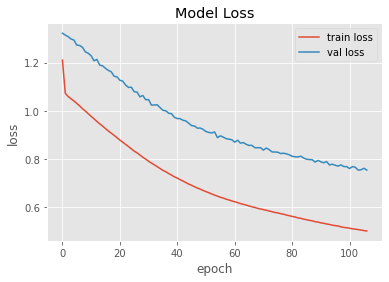

Train Loss:  0.5010660290718079
Validation Loss:  0.7538307905197144


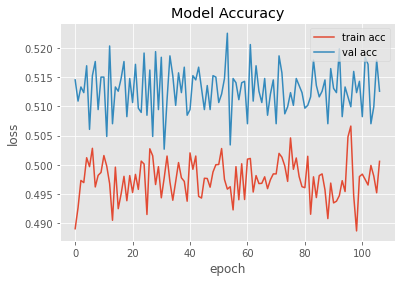

Train Accuracy:  0.5005794763565063
Validation Accuracy:  0.5125969052314758


In [51]:
plot_history(history)

In [76]:
acc, threshold = test_model('../weights\snn-adam-1e6-32-model-03.h5')
acc, threshold

(0.5002472799208705, 0.001271053566597402)

[[Back to Table of Contents]](#Table-of-Contents)

#### SGD

<b>Learning rate: 1e-3</b>

In [45]:
# compile model using adam Optimizer and Contrastive loss function defined above
sgd = SGD(learning_rate=1e-3, momentum=0.1)
model.compile(optimizer=sgd, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [46]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-sgd-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [42]:
history = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//batch_size,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, batch_size),
                    validation_steps=num_val_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.0748 - acc: 0.4972
Epoch 1: saving model to ../weights\snn-sgd-model-01.h5
120/120 [==============================] - 17s 131ms/step - loss: 1.0748 - acc: 0.4972 - val_loss: 1.3350 - val_acc: 0.5145
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 1.0741 - acc: 0.4935
Epoch 2: saving model to ../weights\snn-sgd-model-02.h5
120/120 [==============================] - 16s 132ms/step - loss: 1.0741 - acc: 0.4935 - val_loss: 1.3345 - val_acc: 0.5142
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 1.0744 - acc: 0.4978
Epoch 3: saving model to ../weights\snn-sgd-model-03.h5
120/120 [==============================] - 16s 130ms/step - loss: 1.0744 - acc: 0.4978 - val_loss: 1.3318 - val_acc: 0.5117
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 1.0745 - acc: 0.4970
Epoch 4: saving model to ../weights\snn-sgd-model-04.h5
120/120 [===========================

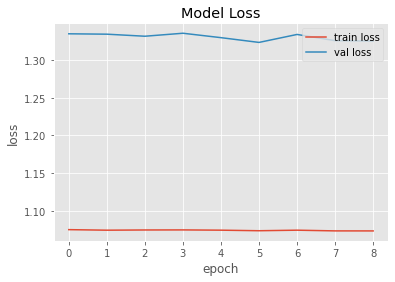

Train Loss:  1.0731148719787598
Validation Loss:  1.3253602981567383


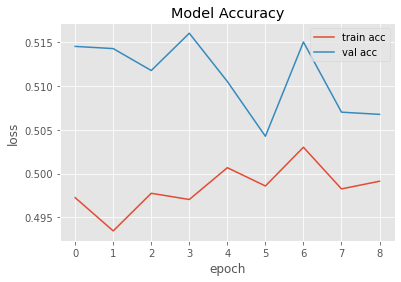

Train Accuracy:  0.49912500381469727
Validation Accuracy:  0.5067499876022339


In [43]:
plot_history(history)

In [ ]:
acc, threshold = test_model('../weights/snn-sgd-model-05.h5')
acc, threshold

<b>learning_rate=1e-4, batch_size=32<b>

In [39]:
# compile model using adam Optimizer and Contrastive loss function defined above
sgd = SGD(learning_rate=1e-4)
model.compile(optimizer=sgd, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [40]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-sgd-32-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [41]:
history = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//32,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 32),
                    validation_steps=num_val_samples//32,
                    callbacks=callbacks)

Epoch 1/100
755/755 [==============================] - ETA: 0s - loss: 1.6879 - acc: 0.4939
Epoch 1: saving model to ../weights\snn-sgd-32-model-01.h5
755/755 [==============================] - 117s 149ms/step - loss: 1.6879 - acc: 0.4939 - val_loss: 1.3281 - val_acc: 0.5087
Epoch 2/100
755/755 [==============================] - ETA: 0s - loss: 1.0750 - acc: 0.4975
Epoch 2: saving model to ../weights\snn-sgd-32-model-02.h5
755/755 [==============================] - 112s 149ms/step - loss: 1.0750 - acc: 0.4975 - val_loss: 1.3360 - val_acc: 0.5167
Epoch 3/100
755/755 [==============================] - ETA: 0s - loss: 1.0750 - acc: 0.4998
Epoch 3: saving model to ../weights\snn-sgd-32-model-03.h5
755/755 [==============================] - 112s 149ms/step - loss: 1.0750 - acc: 0.4998 - val_loss: 1.3322 - val_acc: 0.5131
Epoch 4/100
755/755 [==============================] - ETA: 0s - loss: 1.0747 - acc: 0.4980
Epoch 4: saving model to ../weights\snn-sgd-32-model-04.h5
755/755 [============

In [44]:
# compile model using adam Optimizer and Contrastive loss function defined above
sgd = SGD(learning_rate=1e-4)
model.compile(optimizer=sgd, loss=contrastive_loss, metrics='acc')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          4888208     ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [81]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-sgd-64-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [82]:
history = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//64,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, 64),
                    validation_steps=num_val_samples//64,
                    callbacks=callbacks)

Epoch 1/100
377/377 [==============================] - ETA: 0s - loss: 1.0741 - acc: 0.4977
Epoch 1: saving model to ../weights\snn-sgd-64-model-01.h5
377/377 [==============================] - 102s 267ms/step - loss: 1.0741 - acc: 0.4977 - val_loss: 1.3305 - val_acc: 0.5122
Epoch 2/100
377/377 [==============================] - ETA: 0s - loss: 1.0736 - acc: 0.4953
Epoch 2: saving model to ../weights\snn-sgd-64-model-02.h5
377/377 [==============================] - 109s 289ms/step - loss: 1.0736 - acc: 0.4953 - val_loss: 1.3307 - val_acc: 0.5122
Epoch 3/100
377/377 [==============================] - ETA: 0s - loss: 1.0740 - acc: 0.4985
Epoch 3: saving model to ../weights\snn-sgd-64-model-03.h5
377/377 [==============================] - 99s 264ms/step - loss: 1.0740 - acc: 0.4985 - val_loss: 1.3357 - val_acc: 0.5173
Epoch 4/100
377/377 [==============================] - ETA: 0s - loss: 1.0737 - acc: 0.4973
Epoch 4: saving model to ../weights\snn-sgd-64-model-04.h5
377/377 [=============

<b>learning_rate=1e-5, batch_size=256<b>

In [ ]:
# compile model using adam Optimizer and Contrastive loss function defined above
sgd = SGD(learning_rate=1e-5)
model.compile(optimizer=sgd, loss=contrastive_loss, metrics='acc')
model.summary()

In [43]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/snn-sgd-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [44]:
history = model.fit(generate_batch(genuine_train, forged_train, batch_size),
                    steps_per_epoch=num_train_samples//batch_size,
                    epochs=100,
                    validation_data=generate_batch(
                        genuine_val, forged_val, batch_size),
                    validation_steps=num_val_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/100
120/120 [==============================] - ETA: 0s - loss: 1.0768 - acc: 0.4997
Epoch 1: saving model to ../weights\snn-sgd-model-01.h5
120/120 [==============================] - 17s 131ms/step - loss: 1.0768 - acc: 0.4997 - val_loss: 1.3347 - val_acc: 0.5132
Epoch 2/100
120/120 [==============================] - ETA: 0s - loss: 1.0767 - acc: 0.5038
Epoch 2: saving model to ../weights\snn-sgd-model-02.h5
120/120 [==============================] - 16s 132ms/step - loss: 1.0767 - acc: 0.5038 - val_loss: 1.3284 - val_acc: 0.5070
Epoch 3/100
120/120 [==============================] - ETA: 0s - loss: 1.0759 - acc: 0.4959
Epoch 3: saving model to ../weights\snn-sgd-model-03.h5
120/120 [==============================] - 16s 131ms/step - loss: 1.0759 - acc: 0.4959 - val_loss: 1.3399 - val_acc: 0.5185
Epoch 4/100
120/120 [==============================] - ETA: 0s - loss: 1.0771 - acc: 0.4997
Epoch 4: saving model to ../weights\snn-sgd-model-04.h5
120/120 [===========================

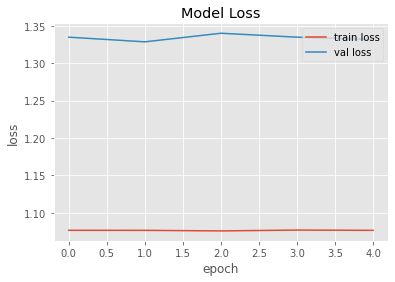

Train Loss:  1.0766985416412354
Validation Loss:  1.331686019897461


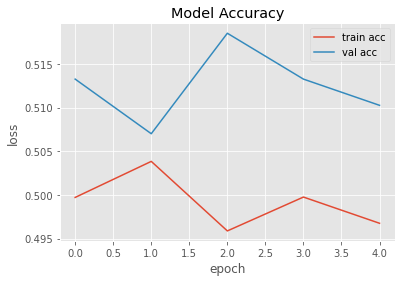

Train Accuracy:  0.49674999713897705
Validation Accuracy:  0.5102499723434448


In [47]:
plot_history(history)

In [78]:
acc, threshold = test_model('../weights/snn-sgd-model-01.h5')
acc, threshold

(0.6257224697809088, 0.010465648656245321)

### Transfer Learning using Inception V3

Load images as rgb as Inception V3 requires input shape with 3 channels.

In [42]:
sub, features, labels, features_forged, features_real, features_dict, X_train, X_test, y_train, y_test, X_val, y_val = load_data(
    load_grayscale=False)

Searching folder 1
Adding ../datasets/signatures_full/train/forged/forged_person/1/1.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/10.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/11.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/12.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/13.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/14.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/15.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/16.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/17.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/18.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/1/19.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_per

Adding ../datasets/signatures_full/train/forged/forged_person/25/4.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/25/5.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/25/6.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/25/7.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/25/8.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/25/9.png with label 0
Searching folder 26
Adding ../datasets/signatures_full/train/forged/forged_person/26/1.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/26/10.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/26/11.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/26/12.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/26/13.png with label 0
Adding ../datasets/signatures_full/train/forged/forg

Adding ../datasets/signatures_full/train/forged/forged_person/41/2.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/20.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/3.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/4.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/5.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/6.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/7.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/8.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/41/9.png with label 0
Searching folder 42
Adding ../datasets/signatures_full/train/forged/forged_person/42/1.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/42/10.png with label 0
Adding ../datasets/signatures_full/train/forged/forged

Adding ../datasets/signatures_full/train/forged/forged_person/8/4.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/8/5.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/8/6.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/8/7.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/8/8.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/8/9.png with label 0
Searching folder 9
Adding ../datasets/signatures_full/train/forged/forged_person/9/1.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/9/10.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/9/11.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/9/12.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/9/13.png with label 0
Adding ../datasets/signatures_full/train/forged/forged_person/9/

In [153]:
X_features, y_labels = load_test_data(load_grayscale=False)

Searching folder 1
Adding ../datasets/signatures_full/test/forged/forged_person/1/1.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/1/2.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/1/3.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/1/4.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/1/5.png with label 0
Searching folder 2
Adding ../datasets/signatures_full/test/forged/forged_person/2/1.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/2/2.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/2/3.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/2/4.png with label 0
Adding ../datasets/signatures_full/test/forged/forged_person/2/5.png with label 0
Searching folder 3
Adding ../datasets/signatures_full/test/forged/forged_person/3/1.png with label 0
Adding ../datasets/signatures_full/test/f

In [122]:
# loading Inception
inception = tf.keras.applications.InceptionV3(
    include_top=False, input_shape=(150, 150, 3))

In [123]:
# freezing layers
for layer in inception.layers:
    layer.trainable = False

In [124]:
x = tf.keras.layers.Flatten()(layer.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
inception_model = tf.keras.Model(inception.input, x)

In [125]:
rms = RMSprop(learning_rate=1e-4)
inception_model.compile(optimizer=rms,
                        loss='binary_crossentropy', metrics=['acc'])
inception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_378 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_388 (Batch  (None, 16, 16, 96)  288         ['conv2d_386[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_389 (Batch  (None, 16, 16, 32)  96          ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_381 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_383[0][0]']
                                                                                                  
 activatio

 activation_398 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_400[0][0]']
                                                                                                  
 conv2d_396 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_399 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_398 (Batch  (None, 16, 16, 48)  144         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_401 (Batch  (None, 16, 16, 96)  288         ['conv2d_399[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_402[0][0]',         
                                                                  'activation_405[0][0]',         
                                                                  'max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_410 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_412 (Batch  (None, 7, 7, 128)   384         ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_410 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_412[0][0]']
          

                                                                                                  
 batch_normalization_422 (Batch  (None, 7, 7, 160)   480         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_420 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_422[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_420[0][0]']         
                                                                                                  
 batch_normalization_423 (Batch  (None, 7, 7, 160)   480         ['conv2d_421[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_431 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_430[0][0]']         
                                                                                                  
 batch_normalization_433 (Batch  (None, 7, 7, 160)   480         ['conv2d_431[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_433[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_43

                                                                                                  
 activation_441 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_443[0][0]']
                                                                                                  
 conv2d_437 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_442 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_441[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 7, 7, 192)   576         ['conv2d_437[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_450 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_449[0][0]']         
                                                                                                  
 batch_normalization_448 (Batch  (None, 7, 7, 192)   576         ['conv2d_446[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_452 (Batch  (None, 7, 7, 192)   576         ['conv2d_450[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_446 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_448[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_454 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_456[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_457[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_460[0][0]']
                                                                                                  
 activation_459 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_461[0][0]']
                                                                                                  
 batch_normalization_462 (Batch  (None, 3, 3, 192)   576         ['conv2d_460[0][0]']             
 Normaliza

                                                                                                  
 activation_468 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_470[0][0]']
                                                                                                  
 batch_normalization_471 (Batch  (None, 3, 3, 192)   576         ['conv2d_469[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_461 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_463[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_463[0][0]',         
                                                                  'activation_464[0][0]']         
          

In [126]:
rms = RMSprop(learning_rate=1e-4)

inception_model.compile(
    optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_378 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_388 (Batch  (None, 16, 16, 96)  288         ['conv2d_386[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_389 (Batch  (None, 16, 16, 32)  96          ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_381 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_383[0][0]']
                                                                                                  
 activatio

 activation_398 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_400[0][0]']
                                                                                                  
 conv2d_396 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_399 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_398 (Batch  (None, 16, 16, 48)  144         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_401 (Batch  (None, 16, 16, 96)  288         ['conv2d_399[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_402[0][0]',         
                                                                  'activation_405[0][0]',         
                                                                  'max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_410 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_412 (Batch  (None, 7, 7, 128)   384         ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_410 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_412[0][0]']
          

                                                                                                  
 batch_normalization_422 (Batch  (None, 7, 7, 160)   480         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_420 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_422[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_420[0][0]']         
                                                                                                  
 batch_normalization_423 (Batch  (None, 7, 7, 160)   480         ['conv2d_421[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_431 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_430[0][0]']         
                                                                                                  
 batch_normalization_433 (Batch  (None, 7, 7, 160)   480         ['conv2d_431[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_433[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_43

                                                                                                  
 activation_441 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_443[0][0]']
                                                                                                  
 conv2d_437 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_442 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_441[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 7, 7, 192)   576         ['conv2d_437[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_450 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_449[0][0]']         
                                                                                                  
 batch_normalization_448 (Batch  (None, 7, 7, 192)   576         ['conv2d_446[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_452 (Batch  (None, 7, 7, 192)   576         ['conv2d_450[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_446 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_448[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_454 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_456[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_457[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_460[0][0]']
                                                                                                  
 activation_459 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_461[0][0]']
                                                                                                  
 batch_normalization_462 (Batch  (None, 3, 3, 192)   576         ['conv2d_460[0][0]']             
 Normaliza

                                                                                                  
 activation_468 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_470[0][0]']
                                                                                                  
 batch_normalization_471 (Batch  (None, 3, 3, 192)   576         ['conv2d_469[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_461 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_463[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_463[0][0]',         
                                                                  'activation_464[0][0]']         
          

In [127]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/inception-rms-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [128]:
inception3_history = inception_model.fit(X_train, y_train, validation_data=(
    X_val, y_val), epochs=50, callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 144.3097 - acc: 0.5182
Epoch 1: saving model to ../weights\inception-rms-model-01.h5
39/39 [==============================] - 8s 89ms/step - loss: 144.3097 - acc: 0.5182 - val_loss: 43.0578 - val_acc: 0.5472
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 80.3474 - acc: 0.5222
Epoch 2: saving model to ../weights\inception-rms-model-02.h5
39/39 [==============================] - 2s 61ms/step - loss: 80.3474 - acc: 0.5222 - val_loss: 23.0609 - val_acc: 0.5690
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 56.0170 - acc: 0.5230
Epoch 3: saving model to ../weights\inception-rms-model-03.h5
39/39 [==============================] - 2s 63ms/step - loss: 56.0170 - acc: 0.5230 - val_loss: 59.5204 - val_acc: 0.4552
Epoch 4/50
38/39 [============================>.] - ETA: 0s - loss: 32.5195 - acc: 0.5370
Epoch 4: saving model to ../weights\inception-rms-model-04.h5
39/39 [=================

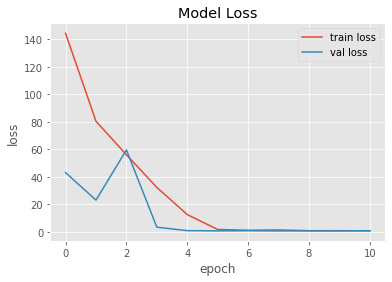

Train Loss:  0.6997246742248535
Validation Loss:  0.8327557444572449


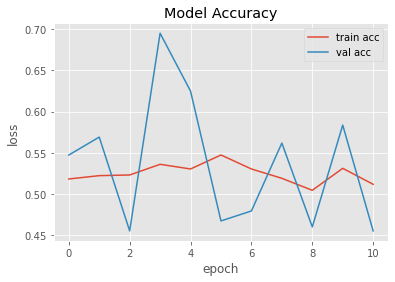

Train Accuracy:  0.5117219090461731
Validation Accuracy:  0.4552057981491089


In [129]:
plot_history(inception3_history)

In [130]:
preds = inception_model.predict(X_test)
pred_labels = []

In [131]:
# threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)

In [132]:
print('Accuracy on test dataset: {}'.format(
    accuracy_score(y_test, pred_labels)))

Accuracy on test dataset: 0.5109090909090909


In [136]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        '../weights/inception-rms-model-{epoch:02d}.h5', verbose=1, restore_best_weights=True)
]

In [137]:
rms = RMSprop(learning_rate=1e-5)

inception_model.compile(
    optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_378 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_388 (Batch  (None, 16, 16, 96)  288         ['conv2d_386[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_389 (Batch  (None, 16, 16, 32)  96          ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_381 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_383[0][0]']
                                                                                                  
 activatio

 activation_398 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_400[0][0]']
                                                                                                  
 conv2d_396 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_399 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_398 (Batch  (None, 16, 16, 48)  144         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_401 (Batch  (None, 16, 16, 96)  288         ['conv2d_399[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_402[0][0]',         
                                                                  'activation_405[0][0]',         
                                                                  'max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_410 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_412 (Batch  (None, 7, 7, 128)   384         ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_410 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_412[0][0]']
          

                                                                                                  
 batch_normalization_422 (Batch  (None, 7, 7, 160)   480         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_420 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_422[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_420[0][0]']         
                                                                                                  
 batch_normalization_423 (Batch  (None, 7, 7, 160)   480         ['conv2d_421[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_431 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_430[0][0]']         
                                                                                                  
 batch_normalization_433 (Batch  (None, 7, 7, 160)   480         ['conv2d_431[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_433[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_43

                                                                                                  
 activation_441 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_443[0][0]']
                                                                                                  
 conv2d_437 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_442 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_441[0][0]']         
                                                                                                  
 batch_normalization_439 (Batch  (None, 7, 7, 192)   576         ['conv2d_437[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_450 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_449[0][0]']         
                                                                                                  
 batch_normalization_448 (Batch  (None, 7, 7, 192)   576         ['conv2d_446[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_452 (Batch  (None, 7, 7, 192)   576         ['conv2d_450[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_446 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_448[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_454 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_456[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_457[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_460[0][0]']
                                                                                                  
 activation_459 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_461[0][0]']
                                                                                                  
 batch_normalization_462 (Batch  (None, 3, 3, 192)   576         ['conv2d_460[0][0]']             
 Normaliza

                                                                                                  
 activation_468 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_470[0][0]']
                                                                                                  
 batch_normalization_471 (Batch  (None, 3, 3, 192)   576         ['conv2d_469[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_461 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_463[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_463[0][0]',         
                                                                  'activation_464[0][0]']         
          

In [138]:
inception3_history = inception_model.fit(X_train, y_train, validation_data=(
    X_val, y_val), epochs=50, callbacks=callbacks)

Epoch 1/50
38/39 [============================>.] - ETA: 0s - loss: 0.6600 - acc: 0.5913
Epoch 1: saving model to ../weights\inception-rms-model-01.h5
39/39 [==============================] - 8s 110ms/step - loss: 0.6595 - acc: 0.5950 - val_loss: 0.6292 - val_acc: 0.6852
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 0.6551 - acc: 0.6168
Epoch 2: saving model to ../weights\inception-rms-model-02.h5
39/39 [==============================] - 2s 62ms/step - loss: 0.6544 - acc: 0.6168 - val_loss: 0.6308 - val_acc: 0.6441
Epoch 3/50
38/39 [============================>.] - ETA: 0s - loss: 0.6557 - acc: 0.5666
Epoch 3: saving model to ../weights\inception-rms-model-03.h5
39/39 [==============================] - 2s 62ms/step - loss: 0.6553 - acc: 0.5683 - val_loss: 0.6340 - val_acc: 0.6416
Epoch 4/50
38/39 [============================>.] - ETA: 0s - loss: 0.6481 - acc: 0.5979
Epoch 4: saving model to ../weights\inception-rms-model-04.h5
39/39 [============================

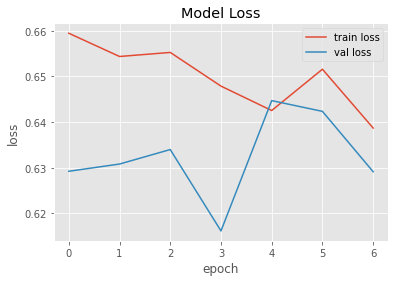

Train Loss:  0.6386943459510803
Validation Loss:  0.6291314959526062


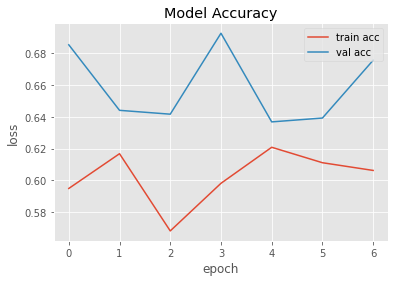

Train Accuracy:  0.6063055992126465
Validation Accuracy:  0.675544798374176


In [139]:
plot_history(inception3_history)

In [142]:
preds = inception_model.predict(X_test)
pred_labels = []

In [143]:
# threshold is 0.5
for p in preds:
    if p >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
pred_labels = np.array(pred_labels)

In [144]:
print('Accuracy on test dataset: {}'.format(
    accuracy_score(y_test, pred_labels)))

Accuracy on test dataset: 0.6454545454545455


[[Back to Table of Contents]](#Table-of-Contents)

## Conclusion

|   Model No. | Optimizer   |   Batch Size |   Learning Rate |   Epoch Number |   Accuracy (%) |
|------------:|:------------|-------------:|----------------:|---------------:|---------------:|
|           1 | Adam        |           32 |          0.0001 |             13 |           65.6 |
|           2 | Adam        |           64 |          0.0001 |             24 |           69.3 |
|           3 | Adam        |          256 |          0.0001 |              8 |           64.8 |
|           4 | Adam        |           32 |          1e-05  |              7 |           65.9 |
|           5 | Adam        |           64 |          1e-05  |             79 |           70.4 |
|           6 | Adam        |          256 |          1e-05  |              2 |           71.4 |
|           7 | RMSprop     |           32 |          0.0001 |              8 |           72.2 |
|           8 | RMSprop     |           64 |          0.0001 |             11 |           69.2 |
|           9 | RMSprop     |          256 |          0.0001 |             25 |           72.1 |
|          10 | RMSprop     |           32 |          1e-05  |              3 |           69.9 |
|          11 | RMSprop     |           64 |          1e-05  |             18 |           68.2 |
|          12 | RMSprop     |          256 |          1e-05  |              0 |           70.7 |

As Siamese Neural Networks work well with insufficient data as in our case (can, we focused on improving the performance of our models through the fine-tuning of the stated optimizers and parameters listed in the score table. Models were also run using Optimizers such as Adagrad and SGD. However, these models did not yield good results as compared to models built using Adam and RMSprop, and hence they were not included in this score table.

Our best model is model no. 7, which gave us an accuracy of 72.2% and a threshold of 0.1519. Signatures that have a difference in euclidean distance from a genuine signature of > 0.1519 will be predicted as forged, while signatures with a difference of less than 0.1519 in euclidean distance will be predicted as genuine. Meantime, 4 out of 5 predictions were output correctly below.

In [236]:
model.load_weights('../weights/snn-rms-le4-32-model-08.h5')

In [237]:
test_genuine = generate_batch(genuine_test, forged_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_genuine)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

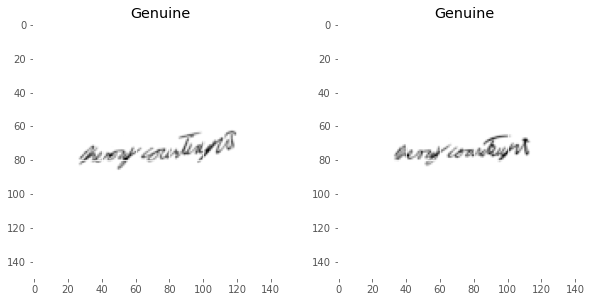

Difference Score =  0.10878546
The signature is genuine


In [147]:
verify_signature()

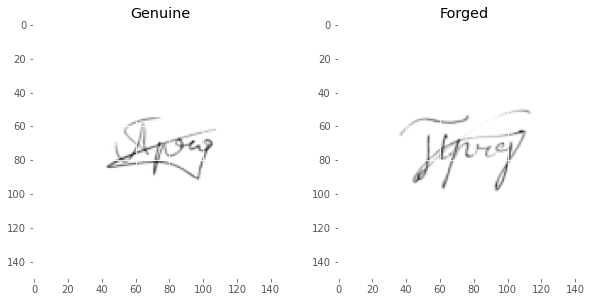

Difference Score =  0.47488528
The signature is forged


In [186]:
verify_signature()

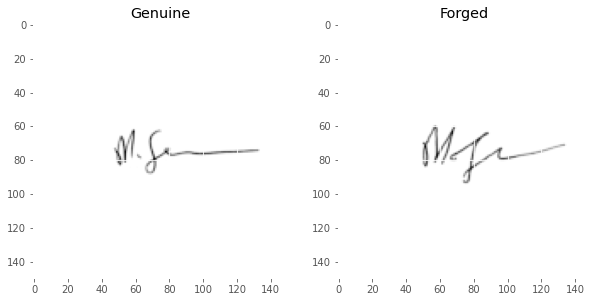

Difference Score =  0.55037856
The signature is forged


In [191]:
verify_signature()

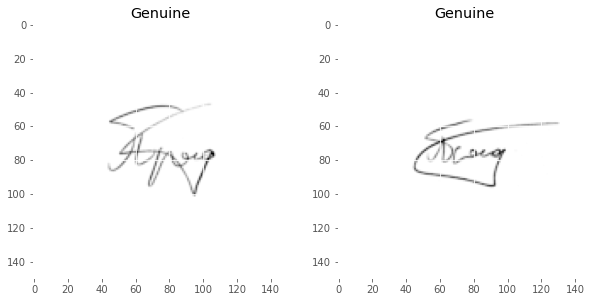

Difference Score =  0.0650725
The signature is genuine


In [165]:
verify_signature()

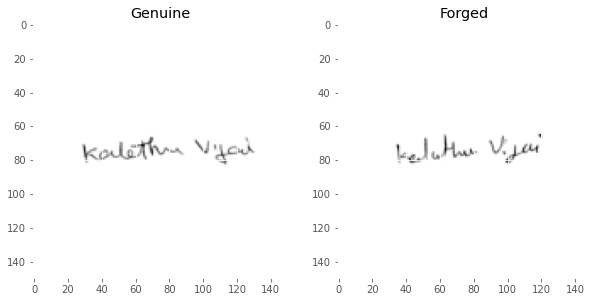

Difference Score =  0.031467725
The signature is genuine


In [207]:
verify_signature()

## Conclusion

SNN will work well 

## Future Works
1. Build model using triplet loss on Siamese Neural Networks (Current models built on contrastive loss)
2. Change model metrics to precision as it is important to detect all forged signatures.
3. Look into pre-trained models and fine-tune the model more.
4. Deploy on web application

## Annex

In [79]:
data = {'Model No.': [1, 2, 3,
                      4, 5, 6,
                      7, 8, 9,
                      10, 11, 12],
        'Optimizer': ['Adam', 'Adam', 'Adam',
                      'Adam', 'Adam', 'Adam',
                      'RMSprop', 'RMSprop', 'RMSprop',
                      'RMSprop', 'RMSprop', 'RMSprop'],
        'Batch Size': [32, 64, 256,
                       32, 64, 256,
                       32, 64, 256,
                       32, 64, 256],
        'Learning Rate': ['1e-4', '1e-4', '1e-4',
                          '1e-5', '1e-5', '1e-5',
                          '1e-4', '1e-4', '1e-4',
                          '1e-5', '1e-5', '1e-5'],
        'Epoch Number': [13, 24, 8,
                         7, 79, 2,
                         8, 11, 25,
                         3, 18, 0],
        'Accuracy (%)': [65.6, 69.3, 64.8,
                         65.9, 70.4, 71.4,
                         72.2, 69.2, 72.1,
                         69.9, 68.2, 70.7]}

In [80]:
# Create DataFrame
df = pd.DataFrame(data)

In [81]:
print(df.to_markdown(index=False))

|   Model No. | Optimizer   |   Batch Size |   Learning Rate |   Epoch Number |   Accuracy (%) |
|------------:|:------------|-------------:|----------------:|---------------:|---------------:|
|           1 | Adam        |           32 |          0.0001 |             13 |           65.6 |
|           2 | Adam        |           64 |          0.0001 |             24 |           69.3 |
|           3 | Adam        |          256 |          0.0001 |              8 |           64.8 |
|           4 | Adam        |           32 |          1e-05  |              7 |           65.9 |
|           5 | Adam        |           64 |          1e-05  |             79 |           70.4 |
|           6 | Adam        |          256 |          1e-05  |              2 |           71.4 |
|           7 | RMSprop     |           32 |          0.0001 |              8 |           72.2 |
|           8 | RMSprop     |           64 |          0.0001 |             11 |           69.2 |
|           9 | RMSprop     | 

[[Back to Table of Contents]](#Table-of-Contents)